
## Title-Lift Pipeline (Stage A + Stage B)



In [38]:
# --- Imports ---
import json
import math
import os
from itertools import combinations
from pathlib import Path

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import seaborn as sns
import statsmodels.api as sm

# Scikit-learn components
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVR

# Display & I/O
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 120)

DATA_FILE = Path('data/features.parquet')  # produced by src.cli.make_features
OUTPUT_DIR = Path('outputs/title_lift')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42

In [39]:

# --- Resolve project + data paths ---
ANCHOR_FILES = ('requirements.txt', 'PROJECT_STATUS.md', '.git')
ONE_DRIVE_HINT = Path.home() / 'OneDrive' / 'Documents' / 'RowanMastersClassesFiles' / 'DataMining1' / 'FinalProject'

def find_project_root() -> Path:
    hints = []
    env_root = os.environ.get('TITLE_LIFT_PROJECT_ROOT')
    if env_root:
        hints.append(Path(env_root))
    cwd = Path.cwd().resolve()
    hints.extend([cwd] + list(cwd.parents))
    if ONE_DRIVE_HINT.exists():
        hints.append(ONE_DRIVE_HINT)
    seen = set()
    for hint in hints:
        if hint is None:
            continue
        candidate = Path(hint).expanduser().resolve(strict=False)
        key = str(candidate)
        if key in seen:
            continue
        seen.add(key)
        if any((candidate / anchor).exists() for anchor in ANCHOR_FILES):
            return candidate
    return cwd

def resolve_data_path(data_file: Path, project_root: Path) -> Path:
    env_data = os.environ.get('TITLE_LIFT_DATA_PATH')
    if env_data:
        env_candidate = Path(env_data).expanduser().resolve(strict=False)
        if env_candidate.exists() and env_candidate.is_file():
            return env_candidate
    candidates = []
    if data_file.is_absolute():
        candidates.append(data_file)
    else:
        candidates.append(data_file)
        if project_root.exists():
            candidates.append(project_root / data_file)
            if data_file.parent == Path('.'):
                candidates.append(project_root / 'data' / data_file.name)
        cwd = Path.cwd().resolve()
        candidates.append(cwd / data_file)
        if data_file.parent == Path('.'):
            candidates.append(cwd / 'data' / data_file.name)
        if ONE_DRIVE_HINT.exists():
            candidates.append(ONE_DRIVE_HINT / data_file)
    seen_paths = set()
    for candidate in candidates:
        if candidate is None:
            continue
        resolved = Path(candidate).expanduser().resolve(strict=False)
        key = str(resolved)
        if key in seen_paths:
            continue
        seen_paths.add(key)
        if resolved.exists() and resolved.is_file():
            return resolved
    if project_root.exists():
        matches = list(project_root.glob(f'**/{data_file.name}'))
        for match in matches:
            if match.is_file():
                return match.resolve(strict=False)
    raise FileNotFoundError(f'Cannot locate dataset for {data_file}')

PROJECT_ROOT = find_project_root()
INPUT_PATH = resolve_data_path(DATA_FILE, PROJECT_ROOT)
print('Project root:', PROJECT_ROOT)
print('Resolved dataset path:', INPUT_PATH)

Project root: C:\Users\patri\OneDrive\Documents\RowanMastersClassesFiles\DataMining1\FinalProject
Resolved dataset path: C:\Users\patri\OneDrive\Documents\RowanMastersClassesFiles\DataMining1\FinalProject\data\features.parquet


In [40]:

# --- Load data ---
def load_any(path: Path) -> pd.DataFrame:
    if path.suffix and path.exists():
        if path.suffix == '.parquet':
            return pd.read_parquet(path)
        if path.suffix == '.csv':
            return pd.read_csv(path)
    for suffix in ('.parquet', '.csv'):
        candidate = path.with_suffix(suffix)
        if candidate.exists():
            return pd.read_parquet(candidate) if suffix == '.parquet' else pd.read_csv(candidate)
    raise FileNotFoundError(f'Cannot locate dataset for {path}')

df = load_any(INPUT_PATH)
print('Loaded:', df.shape, 'from', INPUT_PATH)
df.head(3)

Loaded: (13395, 90) from C:\Users\patri\OneDrive\Documents\RowanMastersClassesFiles\DataMining1\FinalProject\data\features.parquet


,platform,post_id,title,created_timestamp,score,comment_count,author_hash,upvote_ratio,subreddit,is_self_post,url,domain,text_content,is_nsfw,is_spoiler,is_stickied,collection_type,collection_run_id,ingested_timestamp,collection_type_detail,is_new_collection,subreddit_avg_score,subreddit_median_score,subreddit_post_count_global,subreddit_score_std,author_avg_score,author_post_count_global,title_length,title_words,title_chars_per_word,has_question,has_exclamation,punctuation_count,all_caps_words,capitalization_ratio,number_count,has_numbers,sentiment_compound,sentiment_positive,sentiment_negative,sentiment_neutral,flesch_kincaid_grade,avg_word_length,type_token_ratio,clickbait_keywords,clickbait_patterns,has_clickbait,person_entities,org_entities,date_entities,total_entities,hour_of_day,is_morning,is_afternoon,is_evening,is_night,day_of_week,is_weekend,is_monday,is_friday,age_hours,is_very_new,is_recent,is_old,log_age_hours,hour_sin,hour_cos,is_text_post,is_image_post,is_news_post,is_external_link,has_author,author_post_count,is_frequent_poster,author_post_count_log,subreddit_post_count,score_at_5min,score_at_15min,growth_rate_15min,score_at_30min,growth_rate_30min,score_at_60min,growth_rate_60min,early_momentum,sustained_growth,score_5m,score_15m,score_30m,score_60m,velocity_5_to_30m
0,reddit,1oc03pf,Tron: Ares is on track to become a box office ...,1.761011e+09,1946,231,b31aed41,0.98,business,False,https://www.gamesradar.com/entertainment/sci-f...,gamesradar.com,,False,False,False,None,None,NaN,None,0,74.680498,1.0,482,249.604689,936.185185,243,112,22,5.090909,0,0,3,0,0.035294,1,1,-0.7096,0.0,0.228,0.772,9.080909,4.136364,0.863636,0,0,0,0,1,0,1,1,0,0,0,1,1,0,0,0,690.806314,0,0,1,6.539306,0.258819,0.965926,0,0,0,1,1,243,1,5.497168,482,1955.0,1955.0,0.0,1955.0,0.0,1955.0,0.0,0.999489,0,1955.0,1955.0,1955.0,1955.0,0.0
1,reddit,1nxj54x,Costco to sell Ozempic and Wegovy at a large d...,1.759548e+09,1916,150,b31aed41,0.98,business,False,https://www.nbcnews.com/news/amp/rcna235471,nbcnews.com,,False,False,False,None,None,NaN,None,0,74.680498,1.0,482,249.604689,936.185185,243,82,14,5.857143,0,0,0,0,0.043478,0,0,0.0000,0.0,0.000,1.000,8.412857,4.928571,1.000000,0,0,0,0,3,0,3,3,0,0,0,1,5,1,0,0,1097.207703,0,0,1,7.001435,0.707107,0.707107,0,0,0,1,1,243,1,5.497168,482,1916.0,1916.0,0.0,1916.0,0.0,1916.0,0.0,0.999478,0,1916.0,1916.0,1916.0,1916.0,0.0
2,reddit,1ojbmz0,Kraft Heinz CEO Warns of Worst Consumer Sentim...,1.761761e+09,1781,205,b4d96c28,0.98,business,False,https://www.bloomberg.com/news/articles/2025-1...,bloomberg.com,,False,False,False,None,None,NaN,None,0,74.680498,1.0,482,249.604689,656.666667,3,58,10,5.800000,0,0,0,1,0.204082,0,0,-0.6705,0.0,0.407,0.593,4.830000,4.900000,1.000000,0,0,0,1,2,0,3,17,0,1,0,0,2,0,0,0,482.463814,0,0,1,6.180976,-0.965926,-0.258819,0,0,0,1,1,3,0,1.386294,482,1827.0,1827.0,0.0,1827.0,0.0,1827.0,0.0,0.999453,0,1827.0,1827.0,1827.0,1827.0,0.0


In [41]:

# --- Hygiene ---
df = df.copy()

# Ensure key string columns exist and are clean
for col in ['title', 'domain', 'subreddit', 'platform', 'collection_type']:
    if col not in df.columns:
        df[col] = '' if col != 'platform' else 'unknown'
    fill_value = 'unknown' if col in ['platform', 'collection_type'] else ''
    df[col] = df[col].fillna(fill_value).astype(str)

# Harmonize timestamps to derive hour/day if needed
created_dt = None
if 'created_timestamp' in df.columns:
    created_dt = pd.to_datetime(df['created_timestamp'], utc=True, errors='coerce')
elif 'created_utc' in df.columns:
    created_dt = pd.to_datetime(df['created_utc'], unit='s', utc=True, errors='coerce')
if created_dt is not None:
    df['created_dt'] = created_dt
    if 'hour_of_day' not in df.columns:
        df['hour_of_day'] = created_dt.dt.hour
    if 'day_of_week' not in df.columns:
        df['day_of_week'] = created_dt.dt.weekday

# Determine early / outcome columns from available signals
EARLY_CANDIDATES = [col for col in ['score_5m', 'score_15m', 'score_30m', 'score_60m'] if col in df.columns]
if not EARLY_CANDIDATES:
    raise ValueError('Feature dataset needs at least one early score column (score_5m/15m/30m/60m).')
EARLY_COL = EARLY_CANDIDATES[0]
ALT_EARLY_COLS = EARLY_CANDIDATES[1:]

OUTCOME_CANDIDATES = ['score_60m', 'score', 'score_final']
OUTCOME_COL = next((col for col in OUTCOME_CANDIDATES if col in df.columns), None)
if OUTCOME_COL is None:
    raise ValueError('Outcome column not found; expected one of score_60m, score, score_final.')

# Fill aggregate features if feature builder was skipped
if 'subreddit_avg_score' not in df.columns:
    df['subreddit_avg_score'] = df.groupby('subreddit')[OUTCOME_COL].transform('mean')
df['subreddit_avg_score'] = df['subreddit_avg_score'].fillna(df[OUTCOME_COL].median())

if 'subreddit_score_std' not in df.columns:
    df['subreddit_score_std'] = df.groupby('subreddit')[OUTCOME_COL].transform('std')
df['subreddit_score_std'] = df['subreddit_score_std'].fillna(0.0)

if 'author_post_count_global' not in df.columns:
    if 'author_hash' in df.columns:
        df['author_post_count_global'] = df.groupby('author_hash')['author_hash'].transform('count')
    else:
        df['author_post_count_global'] = 0.0
df['author_post_count_global'] = df['author_post_count_global'].fillna(0.0).astype(float)

if 'author_avg_score' not in df.columns:
    if 'author_hash' in df.columns:
        df['author_avg_score'] = df.groupby('author_hash')[OUTCOME_COL].transform('mean')
    else:
        df['author_avg_score'] = df[OUTCOME_COL].median()
df['author_avg_score'] = df['author_avg_score'].fillna(df['author_avg_score'].median()).astype(float)

# Binary flags
df['is_self'] = df.get('is_self_post', df.get('is_self', 0)).fillna(0).astype(int)
df['is_image'] = df['domain'].str.lower().isin({'i.redd.it', 'i.imgur.com', 'imgur.com'}).astype(int)
df['is_new_collection'] = df.get('is_new_collection', 0).fillna(0).astype(int)

# Drop rows missing required signals
required_cols = ['subreddit', 'hour_of_day', 'day_of_week', EARLY_COL, OUTCOME_COL]
df = df.dropna(subset=required_cols)

# Stabilize log scale targets
df['y'] = np.log1p(df[OUTCOME_COL].astype(float).clip(lower=0))
df['E'] = np.log1p(df[EARLY_COL].astype(float).clip(lower=0))

print('Prepared:', df.shape, 'Outcome:', OUTCOME_COL, 'Early:', EARLY_COL)
preview_cols = [EARLY_COL, OUTCOME_COL, 'y', 'E', 'hour_of_day', 'day_of_week', 'is_self', 'is_image']
print(df[preview_cols].head(3))

Prepared: (13395, 95) Outcome: score_60m Early: score_5m
   score_5m  score_60m         y         E  hour_of_day  day_of_week  is_self  is_image
0    1955.0     1955.0  7.578657  7.578657            1            1        0         0
1    1916.0     1916.0  7.558517  7.558517            3            5        0         0
2    1827.0     1827.0  7.510978  7.510978           17            2        0         0


In [42]:
dataset_profile = {
    "rows": int(len(df)),
    "platforms": df['platform'].nunique() if 'platform' in df.columns else 0,
    "subreddits": df['subreddit'].nunique() if 'subreddit' in df.columns else 0,
    "snapshot_columns": {col: (col in df.columns) for col in ['score_5m', 'score_15m', 'score_30m', 'score_60m']}
}
valid_times = df['created_dt'].dropna() if 'created_dt' in df.columns else pd.Series([], dtype='datetime64[ns]')
if not valid_times.empty:
    dataset_profile["time_range"] = (
        valid_times.min().strftime('%Y-%m-%d %H:%M'),
        valid_times.max().strftime('%Y-%m-%d %H:%M')
    )
else:
    dataset_profile["time_range"] = (None, None)

print("Total posts:", dataset_profile["rows"])
if dataset_profile["platforms"]:
    print("Platforms (top 5 counts):")
    display(df['platform'].value_counts().head(5))
if dataset_profile["subreddits"]:
    print("Subreddits represented:", dataset_profile["subreddits"])
print("Snapshot columns present:", dataset_profile["snapshot_columns"])
if all(dataset_profile["time_range"]):
    print("Collection window:", " → ".join(dataset_profile["time_range"]))

sentiment_cols = [col for col in df.columns if col.startswith('sentiment_')]
clickbait_cols = [col for col in df.columns if col.startswith('clickbait_') or col == 'has_clickbait']
feature_cols = sentiment_cols + clickbait_cols
if feature_cols:
    summary_table = df[feature_cols].describe().T[['mean', 'std', 'min', 'max']].round(3)
    print("Sentiment/Clickbait feature summary:")
    display(summary_table)
else:
    print("Sentiment and clickbait features unavailable; rerun feature engineering if needed.")

Total posts: 13395
Platforms (top 5 counts):


platform
reddit    13395
Name: count, dtype: int64

Subreddits represented: 11
Snapshot columns present: {'score_5m': True, 'score_15m': True, 'score_30m': True, 'score_60m': True}
Collection window: 1970-01-01 00:00 → 1970-01-01 00:00
Sentiment/Clickbait feature summary:


,mean,std,min,max
sentiment_compound,-0.055,0.388,-0.979,0.962
sentiment_positive,0.074,0.118,0.000,1.000
sentiment_negative,0.101,0.135,0.000,0.775
sentiment_neutral,0.824,0.165,0.000,1.000
clickbait_keywords,0.018,0.138,0.000,2.000
clickbait_patterns,0.021,0.146,0.000,2.000
has_clickbait,0.036,0.186,0.000,1.000



## Stage A — Intrinsic (Exposure-Adjusted) Baseline

We fit a model that predicts the stabilized outcome `y = log(1 + score_6hr)` from **early exposure** `E = log(1 + score_5m)` and **context** (hour, day, subreddit, content-type, author frequency).

> No title features here — by design — so title effects are not absorbed into the baseline.


In [43]:
# --- Stage A: Intrinsic baseline ---
if 'y' not in df.columns or 'E' not in df.columns:
    raise ValueError('Stage A requires the stabilized outcome `y` and exposure `E`; run the prep cell first.')

categorical_terms = []
if 'platform' in df.columns:
    categorical_terms.append('platform')
if 'collection_type' in df.columns and df['collection_type'].nunique() > 1:
    categorical_terms.append('collection_type')
if 'subreddit' in df.columns and df['subreddit'].nunique() > 1:
    categorical_terms.append('subreddit')
if 'hour_of_day' in df.columns:
    categorical_terms.append('hour_of_day')
if 'day_of_week' in df.columns:
    categorical_terms.append('day_of_week')

numeric_candidates = [
    'is_self',
    'is_image',
    'is_new_collection',
    'author_post_count_global',
    'author_avg_score',
    'subreddit_avg_score',
    'subreddit_score_std'
 ]
numeric_terms = []
for candidate in numeric_candidates:
    if candidate in df.columns:
        df[candidate] = pd.to_numeric(df[candidate], errors='coerce')
        numeric_terms.append(candidate)

stage_a_terms = ['E'] + [f'C({col})' for col in categorical_terms] + numeric_terms
if len(stage_a_terms) == 1:
    print('Warning: Stage A baseline only has the exposure term; context columns were not found.')

stage_a_model_cols = ['y', 'E'] + categorical_terms + numeric_terms
model_df = df.loc[:, stage_a_model_cols].replace([np.inf, -np.inf], np.nan)
valid_index = model_df.dropna().index
dropped = len(model_df) - len(valid_index)
if len(valid_index) == 0:
    raise ValueError('Stage A cannot fit because no rows remain after dropping missing exposure/context values.')
if dropped > 0:
    print(f'Dropped {dropped} rows before Stage A fit due to missing exposure/context fields.')

df = df.loc[valid_index].copy()
model_df = df.loc[:, stage_a_model_cols].copy()
for col in categorical_terms:
    model_df[col] = model_df[col].astype('category')

formula_A = 'y ~ ' + ' + '.join(stage_a_terms)
print('Stage A formula:', formula_A)

y_A, X_A = patsy.dmatrices(formula_A, data=model_df, return_type='dataframe')
ols_A = sm.OLS(y_A, X_A).fit()
print(ols_A.summary().as_text()[:2000])

df['yhat_A'] = ols_A.predict(X_A)
df['R'] = df['y'] - df['yhat_A']
stage_a_coefficients = (
    pd.DataFrame({
        'feature': ols_A.model.exog_names,
        'coefficient': ols_A.params.to_numpy(),
        'std_error': ols_A.bse.to_numpy()
    })
    .assign(abs_coef=lambda d: d['coefficient'].abs())
    .sort_values('abs_coef', ascending=False)
 )
print(f'Stage A fit complete on {len(df):,} rows with {len(ols_A.params)} parameters.')

if 'hour_of_day' in df.columns:
    calibration = df.groupby('hour_of_day')['R'].agg(['mean', 'count']).reset_index()
    print('\nResidual calibration by hour_of_day (mean, count):')
    print(calibration.head(10))

Stage A formula: y ~ E + C(platform) + C(collection_type) + C(subreddit) + C(hour_of_day) + C(day_of_week) + is_self + is_image + is_new_collection + author_post_count_global + author_avg_score + subreddit_avg_score + subreddit_score_std
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     1402.
Date:                Tue, 09 Dec 2025   Prob (F-statistic):               0.00
Time:                        13:40:34   Log-Likelihood:                -19778.
No. Observations:               13395   AIC:                         3.965e+04
Df Residuals:                   13349   BIC:                         3.999e+04
Df Model:                          45                                         
Covariance Type:            nonrobust              

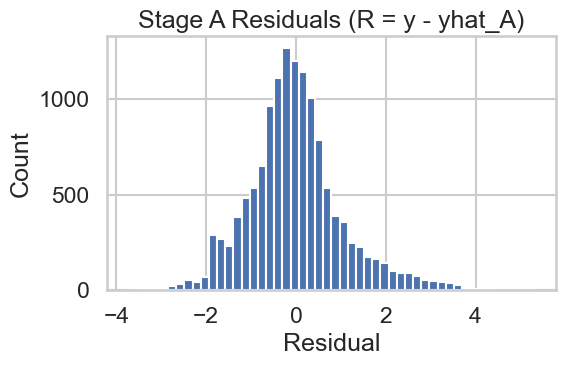

In [44]:

# Plot residual distribution
plt.figure(figsize=(6,4))
plt.hist(df['R'].dropna(), bins=50)
plt.title('Stage A Residuals (R = y - yhat_A)')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


### Stage A Key Drivers
Quantify which contextual and exposure features contribute most to the intrinsic-quality baseline before titles are introduced.

In [45]:
display_df = stage_a_coefficients.copy()
if 'feature' in display_df.columns:
    display_df = display_df[display_df['feature'] != 'Intercept']
else:
    raise ValueError('stage_a_coefficients is missing the "feature" column; rerun the Stage A fit cell.')

display_df = display_df.assign(abs_coef=lambda d: d['coefficient'].abs()).sort_values('abs_coef', ascending=False)
print('Top Stage A contributors (absolute magnitude):')
display(display_df.head(12))
print('\nMost negative Stage A coefficients:')
display(display_df.sort_values('coefficient').head(6)[['feature', 'coefficient', 'std_error']])
print('\nMost positive Stage A coefficients:')
display(display_df.sort_values('coefficient', ascending=False).head(6)[['feature', 'coefficient', 'std_error']])

Top Stage A contributors (absolute magnitude):


,feature,coefficient,std_error,abs_coef
41,E,0.866396,0.006506,0.866396
10,C(subreddit)[T.technology],-0.617187,0.023093,0.617187
42,is_self,-0.526248,0.039784,0.526248
44,is_new_collection,0.442801,0.030756,0.442801
20,C(hour_of_day)[T.9],-0.393415,0.077243,0.393415
3,C(subreddit)[T.economy],-0.379351,0.058337,0.379351
18,C(hour_of_day)[T.7],-0.367211,0.079113,0.367211
17,C(hour_of_day)[T.6],-0.350445,0.082390,0.350445
19,C(hour_of_day)[T.8],-0.291253,0.079420,0.291253
43,is_image,0.265209,0.061875,0.265209



Most negative Stage A coefficients:


,feature,coefficient,std_error
10,C(subreddit)[T.technology],-0.617187,0.023093
42,is_self,-0.526248,0.039784
20,C(hour_of_day)[T.9],-0.393415,0.077243
3,C(subreddit)[T.economy],-0.379351,0.058337
18,C(hour_of_day)[T.7],-0.367211,0.079113
17,C(hour_of_day)[T.6],-0.350445,0.082390



Most positive Stage A coefficients:


,feature,coefficient,std_error
41,E,0.866396,0.006506
44,is_new_collection,0.442801,0.030756
43,is_image,0.265209,0.061875
6,C(subreddit)[T.politics],0.241102,0.028671
11,C(subreddit)[T.worldnews],0.229852,0.025832
7,C(subreddit)[T.science],0.116997,0.035950



## Stage B — Residual Title Lift

We regress residuals `R` on **title features** 


In [46]:
# Stage B — residual title lift (OLS)
from datetime import datetime

title_feature_candidates = [
    'title_length','title_words','title_chars_per_word','has_question','has_numbers',
    'has_exclamation','capitalization_ratio','all_caps_words','number_count',
    'sentiment_compound','sentiment_positive','sentiment_negative','sentiment_neutral',
    'clickbait_patterns','clickbait_keywords','has_clickbait'
]
TITLE_FEATURES = [col for col in title_feature_candidates if col in df.columns]
if not TITLE_FEATURES:
    raise ValueError('No title features detected; ensure feature engineering step ran.')
formula_B = 'R ~ ' + ' + '.join(TITLE_FEATURES)
print('Stage B formula:', formula_B)

y_B, X_B = patsy.dmatrices(formula_B, data=df, return_type='dataframe')
ols_B = sm.OLS(y_B, X_B).fit()
print(ols_B.summary().as_text()[:2000])

df['Rhat_B'] = ols_B.predict(X_B)
df['title_lift_component'] = df['Rhat_B']

interaction_feature = 'has_clickbait' if 'has_clickbait' in TITLE_FEATURES else ('has_numbers' if 'has_numbers' in TITLE_FEATURES else None)
if interaction_feature and 'subreddit' in df.columns and df['subreddit'].nunique() > 1:
    formula_Bx = formula_B + f' + C(subreddit):{interaction_feature}'
    y_Bx, X_Bx = patsy.dmatrices(formula_Bx, data=df, return_type='dataframe')
    ols_Bx = sm.OLS(y_Bx, X_Bx).fit()
    print('\nWith subreddit interaction (truncated):\n', ols_Bx.summary().as_text()[:2000])
else:
    ols_Bx = None

coef_B = ols_B.params.rename('coef').to_frame()
coef_B['se'] = ols_B.bse
coef_path = OUTPUT_DIR / 'stageB_coefs.csv'

try:
    coef_B.to_csv(coef_path)
    stage_b_coef_path = coef_path
    print('Saved Stage B coefficients to', coef_path)
except PermissionError:
    fallback_path = coef_path.with_name(f"{coef_path.stem}_{datetime.now().strftime('%Y%m%d_%H%M%S')}{coef_path.suffix}")
    # Fall back when the canonical CSV is locked (e.g., open in Excel).
    coef_B.to_csv(fallback_path)
    stage_b_coef_path = fallback_path
    print(f'Permission denied writing {coef_path}; saved Stage B coefficients to {fallback_path} instead.')

coef_B.head()

Stage B formula: R ~ title_length + title_words + title_chars_per_word + has_question + has_numbers + has_exclamation + capitalization_ratio + all_caps_words + number_count + sentiment_compound + sentiment_positive + sentiment_negative + sentiment_neutral + clickbait_patterns + clickbait_keywords + has_clickbait
                            OLS Regression Results                            
Dep. Variable:                      R   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     16.20
Date:                Tue, 09 Dec 2025   Prob (F-statistic):           2.08e-45
Time:                        13:40:34   Log-Likelihood:                -19649.
No. Observations:               13395   AIC:                         3.933e+04
Df Residuals:                   13378   BIC:                         3.946e+04
Df Model:                          16                 

,coef,se
Intercept,117.386967,42.182649
title_length,-0.001323,0.000953
title_words,0.021973,0.006006
title_chars_per_word,0.005221,0.006471
has_question,-0.140179,0.036184


## Stage B Variant Check — Mean-Centered Title Features
We re-estimate Stage B after subtracting each title feature’s mean. This sets the intercept to the expected residual lift for an “average” title and lets us compare coefficients, residual fit, and downstream diagnostics against the raw (uncentered) specification.

In [47]:
# --- Stage B (mean-centered comparison) ---
# Keep a separate variant with mean-centered title features to compare coefficients and fit.
center_suffix = '_centered'
centered_feature_map = {f'{col}{center_suffix}': df[col] - df[col].mean() for col in TITLE_FEATURES}
df_center = df.assign(**centered_feature_map)

formula_B_centered = 'R ~ ' + ' + '.join(f'{col}{center_suffix}' for col in TITLE_FEATURES)
print('Stage B (centered) formula:', formula_B_centered)
y_B_center, X_B_center = patsy.dmatrices(formula_B_centered, data=df_center, return_type='dataframe')
ols_B_center = sm.OLS(y_B_center, X_B_center).fit()
print(ols_B_center.summary().as_text()[:2000])

df['Rhat_B_centered'] = ols_B_center.predict(X_B_center)
df['title_lift_component_centered'] = df['Rhat_B_centered']
df['stage_b_prediction_centered'] = df['yhat_A'] + df['title_lift_component_centered']
df['stage_b_residual_centered'] = df['y'] - df['stage_b_prediction_centered']

coef_B_raw = pd.DataFrame({'coef_raw': ols_B.params, 'se_raw': ols_B.bse})
coef_B_centered = pd.DataFrame({'coef_centered': ols_B_center.params, 'se_centered': ols_B_center.bse})
coef_B_centered.index = [idx.replace(center_suffix, '') for idx in coef_B_centered.index]

comparison = (
    coef_B_raw.join(coef_B_centered, how='outer')
                 .assign(abs_coef_raw=lambda d: d['coef_raw'].abs(),
                         abs_coef_centered=lambda d: d['coef_centered'].abs())
                 .sort_index()
)
print('Coefficient comparison (raw vs mean-centered):')
display(comparison.head(12))

stage_b_rmse_centered = float(np.sqrt(np.mean(np.square(df['y'] - df['stage_b_prediction_centered']))))
stage_b_mae_centered = float(np.mean(np.abs(df['y'] - df['stage_b_prediction_centered'])))
print(f'Stage B centered RMSE (log space): {stage_b_rmse_centered:.4f}')
print(f'Stage B centered MAE (log space): {stage_b_mae_centered:.4f}')

Stage B (centered) formula: R ~ title_length_centered + title_words_centered + title_chars_per_word_centered + has_question_centered + has_numbers_centered + has_exclamation_centered + capitalization_ratio_centered + all_caps_words_centered + number_count_centered + sentiment_compound_centered + sentiment_positive_centered + sentiment_negative_centered + sentiment_neutral_centered + clickbait_patterns_centered + clickbait_keywords_centered + has_clickbait_centered
                            OLS Regression Results                            
Dep. Variable:                      R   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     16.20
Date:                Tue, 09 Dec 2025   Prob (F-statistic):           2.08e-45
Time:                        13:40:34   Log-Likelihood:                -19649.
No. Observations:               13395   AIC:             

,coef_raw,se_raw,coef_centered,se_centered,abs_coef_raw,abs_coef_centered
Intercept,117.386967,42.182649,8.616437e-14,0.009071,117.386967,8.616437e-14
all_caps_words,-0.049470,0.012881,-4.946950e-02,0.012881,0.049470,4.946950e-02
capitalization_ratio,0.011324,0.138817,1.132351e-02,0.138817,0.011324,1.132351e-02
clickbait_keywords,-0.102825,0.186787,-1.028249e-01,0.186787,0.102825,1.028249e-01
clickbait_patterns,-0.206344,0.192848,-2.063444e-01,0.192848,0.206344,2.063444e-01
has_clickbait,0.105977,0.202877,1.059770e-01,0.202877,0.105977,1.059770e-01
has_exclamation,-0.111322,0.101298,-1.113224e-01,0.101298,0.111322,1.113224e-01
has_numbers,0.054623,0.034194,5.462293e-02,0.034194,0.054623,5.462293e-02
has_question,-0.140179,0.036184,-1.401794e-01,0.036184,0.140179,1.401794e-01
number_count,-0.001210,0.017173,-1.209902e-03,0.017173,0.001210,1.209902e-03


Stage B centered RMSE (log space): 1.0491
Stage B centered MAE (log space): 0.7771


In [48]:
# --- Stage B (Elastic Net variant) ---
# Regress residuals on title features with ElasticNetCV to allow sparse feature selection.
X_title = df[TITLE_FEATURES].fillna(0.0)
y_resid = df['R']

elastic_net = Pipeline([
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('model', ElasticNetCV(
        l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
        alphas=np.logspace(-3, 1, 25),  # explicit alpha grid avoids deprecated default
        cv=5,
        n_jobs=None,
        random_state=RANDOM_STATE
    ))
])
elastic_net.fit(X_title, y_resid)

en_model = elastic_net.named_steps['model']
print('Elastic Net best alpha:', round(en_model.alpha_, 6))
print('Elastic Net best l1_ratio:', round(en_model.l1_ratio_, 3))

df['Rhat_B_en'] = elastic_net.predict(X_title)
df['title_lift_component_en'] = df['Rhat_B_en']
df['stage_b_prediction_en'] = df['yhat_A'] + df['title_lift_component_en']
df['stage_b_residual_en'] = df['y'] - df['stage_b_prediction_en']

en_coef = pd.DataFrame({
    'feature': X_title.columns,
    'coef': elastic_net.named_steps['model'].coef_
}).assign(abs_coef=lambda d: d['coef'].abs()).sort_values('abs_coef', ascending=False)
print('Top Elastic Net coefficients (abs):')
display(en_coef.head(10))

Elastic Net best alpha: 0.215443
Elastic Net best l1_ratio: 0.1
Top Elastic Net coefficients (abs):
 0.215443
Elastic Net best l1_ratio: 0.1
Top Elastic Net coefficients (abs):


,feature,coef,abs_coef
1,title_words,0.048278,0.048278
0,title_length,0.035694,0.035694
9,sentiment_compound,-0.031638,0.031638
3,has_question,-0.011235,0.011235
11,sentiment_negative,0.006133,0.006133
4,has_numbers,0.005112,0.005112
7,all_caps_words,-0.002930,0.002930
2,title_chars_per_word,-0.000000,0.000000
5,has_exclamation,-0.000000,0.000000
6,capitalization_ratio,-0.000000,0.000000


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1856
[LightGBM] [Info] Number of data points in the train set: 13395, number of used features: 16
[LightGBM] [Info] Start training from score 0.000000
Top SHAP contributions (LightGBM):
Top SHAP contributions (LightGBM):


,feature,mean_abs_shap
6,capitalization_ratio,0.062610
0,title_length,0.057612
1,title_words,0.055956
11,sentiment_negative,0.053963
2,title_chars_per_word,0.053278
9,sentiment_compound,0.051636
12,sentiment_neutral,0.034874
7,all_caps_words,0.034173
10,sentiment_positive,0.022975
3,has_question,0.014968


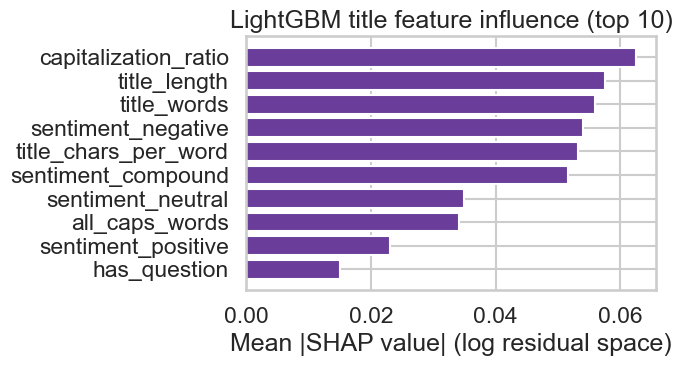

In [49]:

# --- Stage B (LightGBM confirmation + SHAP) ---
# Gradient boosted trees capture non-linear title effects; SHAP quantifies feature influence.
lgb_params = dict(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1
 )
lgb_model = lgb.LGBMRegressor(**lgb_params)
lgb_model.fit(X_title, y_resid)

df['Rhat_B_lgb'] = lgb_model.predict(X_title)
df['title_lift_component_lgb'] = df['Rhat_B_lgb']
df['stage_b_prediction_lgb'] = df['yhat_A'] + df['title_lift_component_lgb']
df['stage_b_residual_lgb'] = df['y'] - df['stage_b_prediction_lgb']

shap_importance = None
try:
    import shap
    shap_sample = X_title.sample(min(2000, len(X_title)), random_state=RANDOM_STATE)
    explainer = shap.TreeExplainer(lgb_model)
    shap_values = explainer.shap_values(shap_sample)
    if isinstance(shap_values, list):
        shap_values = shap_values[0]
    shap_importance = pd.DataFrame({
        'feature': shap_sample.columns,
        'mean_abs_shap': np.abs(shap_values).mean(axis=0)
    }).sort_values('mean_abs_shap', ascending=False)
    print('Top SHAP contributions (LightGBM):')
    display(shap_importance.head(10))

    fig, ax = plt.subplots(figsize=(7, 4))
    top_shap = shap_importance.head(10).sort_values('mean_abs_shap')
    ax.barh(top_shap['feature'], top_shap['mean_abs_shap'], color='#6a3d9a')
    ax.set_xlabel('Mean |SHAP value| (log residual space)')
    ax.set_title('LightGBM title feature influence (top 10)')
    plt.tight_layout()
    plt.show()
except ImportError:
    print('SHAP is not installed; falling back to LightGBM gain-based importance. Run "pip install shap" if you want SHAP plots.')

if shap_importance is None:
    booster = lgb_model.booster_ if hasattr(lgb_model, 'booster_') else lgb_model.booster
    gain_importance = pd.DataFrame({
        'feature': X_title.columns,
        'gain_importance': booster.feature_importance(importance_type='gain'),
        'split_importance': booster.feature_importance(importance_type='split')
    }).sort_values('gain_importance', ascending=False)
    print('LightGBM gain-based feature importance (fallback):')
    display(gain_importance.head(10))

    fig, ax = plt.subplots(figsize=(7, 4))
    top_gain = gain_importance.head(10).sort_values('gain_importance')
    ax.barh(top_gain['feature'], top_gain['gain_importance'], color='#2ca02c')
    ax.set_xlabel('Gain importance')
    ax.set_title('LightGBM title feature importance (gain, top 10)')
    plt.tight_layout()
    plt.show()


### Post-Run Diagnostics

The cells below summarize Stage A and Stage B behavior, highlight the most influential title features, visualize residual structure, and evaluate pairwise ranking lift after incorporating the title model.

In [50]:
# --- Stage-level diagnostics ---
df['stage_b_prediction'] = df['yhat_A'] + df['title_lift_component']
df['stage_b_residual'] = df['y'] - df['stage_b_prediction']
df['stage_b_gain'] = df['stage_b_prediction'] - df['yhat_A']
df['abs_residual'] = df['R'].abs()
df['abs_stage_b_residual'] = df['stage_b_residual'].abs()

if 'stage_b_prediction_en' in df.columns:
    df['stage_b_gain_en'] = df['stage_b_prediction_en'] - df['yhat_A']
    df['abs_stage_b_residual_en'] = df['stage_b_residual_en'].abs()

if 'stage_b_prediction_lgb' in df.columns:
    df['stage_b_gain_lgb'] = df['stage_b_prediction_lgb'] - df['yhat_A']
    df['abs_stage_b_residual_lgb'] = df['stage_b_residual_lgb'].abs()

if 'stage_b_prediction_centered' in df.columns:
    df['stage_b_gain_centered'] = df['stage_b_prediction_centered'] - df['yhat_A']
    df['abs_stage_b_residual_centered'] = df['stage_b_residual_centered'].abs()

def rmse(actual, pred):
    return float(np.sqrt(np.mean(np.square(actual - pred))))

def mae(actual, pred):
    return float(np.mean(np.abs(actual - pred)))

stage_a_rmse = rmse(df['y'], df['yhat_A'])
stage_a_mae = mae(df['y'], df['yhat_A'])
stage_a_residual_mean = df['R'].mean()
stage_a_residual_std = df['R'].std()

stage_b_rmse = rmse(df['y'], df['stage_b_prediction'])
stage_b_mae = mae(df['y'], df['stage_b_prediction'])
stage_b_residual_mean = df['stage_b_residual'].mean()
stage_b_residual_std = df['stage_b_residual'].std()

metrics_rows = [
    ('Stage A RMSE (log space)', stage_a_rmse),
    ('Stage B RMSE (log space)', stage_b_rmse),
    ('Stage A MAE (log space)', stage_a_mae),
    ('Stage B MAE (log space)', stage_b_mae),
    ('Residual mean (Stage A)', stage_a_residual_mean),
    ('Residual std (Stage A)', stage_a_residual_std),
    ('Residual mean (Stage B)', stage_b_residual_mean),
    ('Residual std (Stage B)', stage_b_residual_std)
 ]

variant_rows = [
    {
        'model': 'Stage A baseline',
        'rmse': stage_a_rmse,
        'mae': stage_a_mae,
        'residual_mean': stage_a_residual_mean,
        'residual_std': stage_a_residual_std,
        'rmse_delta_vs_stage_a': 0.0
    },
    {
        'model': 'Stage A + Stage B (OLS)',
        'rmse': stage_b_rmse,
        'mae': stage_b_mae,
        'residual_mean': stage_b_residual_mean,
        'residual_std': stage_b_residual_std,
        'rmse_delta_vs_stage_a': stage_a_rmse - stage_b_rmse
    }
 ]

if 'stage_b_prediction_centered' in df.columns:
    stage_b_centered_rmse = rmse(df['y'], df['stage_b_prediction_centered'])
    stage_b_centered_mae = mae(df['y'], df['stage_b_prediction_centered'])
    stage_b_centered_residual_mean = df['stage_b_residual_centered'].mean()
    stage_b_centered_residual_std = df['stage_b_residual_centered'].std()
    metrics_rows.extend([
        ('Stage B (Centered) RMSE (log space)', stage_b_centered_rmse),
        ('Stage B (Centered) MAE (log space)', stage_b_centered_mae),
        ('Residual mean (Stage B Centered)', stage_b_centered_residual_mean),
        ('Residual std (Stage B Centered)', stage_b_centered_residual_std)
    ])
    variant_rows.append({
        'model': 'Stage A + Stage B (Centered)',
        'rmse': stage_b_centered_rmse,
        'mae': stage_b_centered_mae,
        'residual_mean': stage_b_centered_residual_mean,
        'residual_std': stage_b_centered_residual_std,
        'rmse_delta_vs_stage_a': stage_a_rmse - stage_b_centered_rmse
    })

if 'stage_b_prediction_en' in df.columns:
    stage_b_en_rmse = rmse(df['y'], df['stage_b_prediction_en'])
    stage_b_en_mae = mae(df['y'], df['stage_b_prediction_en'])
    stage_b_en_residual_mean = df['stage_b_residual_en'].mean()
    stage_b_en_residual_std = df['stage_b_residual_en'].std()
    metrics_rows.extend([
        ('Stage B (Elastic Net) RMSE (log space)', stage_b_en_rmse),
        ('Stage B (Elastic Net) MAE (log space)', stage_b_en_mae),
        ('Residual mean (Stage B Elastic Net)', stage_b_en_residual_mean),
        ('Residual std (Stage B Elastic Net)', stage_b_en_residual_std)
    ])
    variant_rows.append({
        'model': 'Stage A + Stage B (Elastic Net)',
        'rmse': stage_b_en_rmse,
        'mae': stage_b_en_mae,
        'residual_mean': stage_b_en_residual_mean,
        'residual_std': stage_b_en_residual_std,
        'rmse_delta_vs_stage_a': stage_a_rmse - stage_b_en_rmse
    })

if 'stage_b_prediction_lgb' in df.columns:
    stage_b_lgb_rmse = rmse(df['y'], df['stage_b_prediction_lgb'])
    stage_b_lgb_mae = mae(df['y'], df['stage_b_prediction_lgb'])
    stage_b_lgb_residual_mean = df['stage_b_residual_lgb'].mean()
    stage_b_lgb_residual_std = df['stage_b_residual_lgb'].std()
    metrics_rows.extend([
        ('Stage B (LightGBM) RMSE (log space)', stage_b_lgb_rmse),
        ('Stage B (LightGBM) MAE (log space)', stage_b_lgb_mae),
        ('Residual mean (Stage B LightGBM)', stage_b_lgb_residual_mean),
        ('Residual std (Stage B LightGBM)', stage_b_lgb_residual_std)
    ])
    variant_rows.append({
        'model': 'Stage A + Stage B (LightGBM)',
        'rmse': stage_b_lgb_rmse,
        'mae': stage_b_lgb_mae,
        'residual_mean': stage_b_lgb_residual_mean,
        'residual_std': stage_b_lgb_residual_std,
        'rmse_delta_vs_stage_a': stage_a_rmse - stage_b_lgb_rmse
    })

stage_summary = pd.DataFrame(metrics_rows, columns=['metric', 'value']).assign(value=lambda d: d['value'].round(4))
stage_variant_table = pd.DataFrame(variant_rows).round({
    'rmse': 4,
    'mae': 4,
    'residual_mean': 4,
    'residual_std': 4,
    'rmse_delta_vs_stage_a': 4
})

hourly_table = (
    df.groupby('hour_of_day')[['R', 'stage_b_residual']].agg(['mean', 'std', 'count'])
      .round(3)
      .rename_axis('hour_of_day')
)

subreddit_table = (
    df.groupby('subreddit')[['R', 'stage_b_residual']].agg(['mean', 'std', 'count'])
      .sort_values(('R', 'mean'))
      .round(3)
)

display(stage_summary)
print('Stage comparison summary:')
display(stage_variant_table)
display(hourly_table)
display(subreddit_table.head(12))

,metric,value
0,Stage A RMSE (log space),1.0593
1,Stage B RMSE (log space),1.0491
2,Stage A MAE (log space),0.7787
3,Stage B MAE (log space),0.7771
4,Residual mean (Stage A),0.0000
5,Residual std (Stage A),1.0593
6,Residual mean (Stage B),0.0000
7,Residual std (Stage B),1.0492
8,Stage B (Centered) RMSE (log space),1.0491
9,Stage B (Centered) MAE (log space),0.7771


Stage comparison summary:


,model,rmse,mae,residual_mean,residual_std,rmse_delta_vs_stage_a
0,Stage A baseline,1.0593,0.7787,0.0,1.0593,0.0000
1,Stage A + Stage B (OLS),1.0491,0.7771,0.0,1.0492,0.0101
2,Stage A + Stage B (Centered),1.0491,0.7771,0.0,1.0492,0.0101
3,Stage A + Stage B (Elastic Net),1.0515,0.7762,0.0,1.0515,0.0078
4,Stage A + Stage B (LightGBM),0.8697,0.6398,-0.0,0.8697,0.1896


R              stage_b_residual             
            mean    std count             mean    std count
hour_of_day                                                
0            0.0  1.115   503            0.003  1.113   503
1            0.0  1.119   440            0.023  1.121   440
2            0.0  1.124   387            0.020  1.111   387
3            0.0  1.028   405            0.010  1.022   405
4            0.0  0.928   315            0.008  0.924   315
5            0.0  0.917   269            0.022  0.908   269
6            0.0  0.866   249            0.001  0.868   249
7            0.0  0.784   283            0.011  0.791   283
8            0.0  0.873   279            0.011  0.866   279
9            0.0  0.883   306            0.003  0.870   306
10           0.0  0.913   451           -0.028  0.913   451
11           0.0  0.953   540           -0.017  0.936   540
12           0.0  1.046   707           -0.014  1.045   707
13           0.0  1.123   783           -0.006  1.106   783
14           0.0  1.114   829           -0.006  1.108   829
15           0.0  1.133   869           -0.012  1.118   869
16           0.0  1.063   812            0.004  1.053   812
17           0.0  1.064   848           -0.003  1.057   848
18           0.0  1.032   814           -0.007  1.029   814
19           0.0  1.090   755           -0.000  1.069   755
20           0.0  1.122   721            0.002  1.102   721
21           0.0  1.128   761            0.005  1.112   761
22           0.0  1.125   569            0.016  1.116   569
23           0.0  1.135   500            0.004  1.111   500

R              stage_b_residual             
           mean    std count             mean    std count
subreddit                                                 
business   -0.0  0.564   482            0.090  0.582   482
gadgets    -0.0  1.030   218            0.023  1.016   218
technews   -0.0  0.753   439           -0.014  0.758   439
energy     -0.0  0.637   611            0.006  0.611   611
space      -0.0  0.841   748            0.018  0.821   748
Futurology  0.0  0.952   642            0.034  0.936   642
technology  0.0  1.277  1636           -0.006  1.261  1636
science     0.0  1.220   722           -0.184  1.197   722
economy     0.0  0.883  1664            0.005  0.867  1664
worldnews   0.0  1.217  1846           -0.010  1.213  1846
politics    0.0  1.096  4387            0.017  1.087  4387

In [51]:

# --- Title feature importance snapshot ---
coef_display = (
    coef_B.copy()
    .assign(feature=lambda d: d.index)
    .assign(abs_coef=lambda d: d['coef'].abs())
    .sort_values('coef', ascending=False)
    .reset_index(drop=True)
 )

top_positive = coef_display.head(10).copy()
top_negative = coef_display.sort_values('coef').head(10).copy()
top_overall = coef_display.sort_values('abs_coef', ascending=False).head(10).copy()

print('Top 10 positive title effects (log residual space):')
display(top_positive[['feature', 'coef', 'se', 'abs_coef']])

print('Top 10 negative title effects (log residual space):')
display(top_negative[['feature', 'coef', 'se', 'abs_coef']])

print('Top 10 by absolute magnitude:')
display(top_overall[['feature', 'coef', 'se', 'abs_coef']])

Top 10 positive title effects (log residual space):


,feature,coef,se,abs_coef
0,Intercept,117.386967,42.182649,117.386967
1,has_clickbait,0.105977,0.202877,0.105977
2,has_numbers,0.054623,0.034194,0.054623
3,title_words,0.021973,0.006006,0.021973
4,capitalization_ratio,0.011324,0.138817,0.011324
5,title_chars_per_word,0.005221,0.006471,0.005221
6,number_count,-0.001210,0.017173,0.001210
7,title_length,-0.001323,0.000953,0.001323
8,all_caps_words,-0.049470,0.012881,0.049470
9,clickbait_keywords,-0.102825,0.186787,0.102825


Top 10 negative title effects (log residual space):


,feature,coef,se,abs_coef
16,sentiment_neutral,-117.616228,42.182787,117.616228
15,sentiment_negative,-117.574220,42.184938,117.574220
14,sentiment_positive,-117.531320,42.179245,117.531320
13,clickbait_patterns,-0.206344,0.192848,0.206344
12,sentiment_compound,-0.169089,0.058360,0.169089
11,has_question,-0.140179,0.036184,0.140179
10,has_exclamation,-0.111322,0.101298,0.111322
9,clickbait_keywords,-0.102825,0.186787,0.102825
8,all_caps_words,-0.049470,0.012881,0.049470
7,title_length,-0.001323,0.000953,0.001323


Top 10 by absolute magnitude:


,feature,coef,se,abs_coef
16,sentiment_neutral,-117.616228,42.182787,117.616228
15,sentiment_negative,-117.574220,42.184938,117.574220
14,sentiment_positive,-117.531320,42.179245,117.531320
0,Intercept,117.386967,42.182649,117.386967
13,clickbait_patterns,-0.206344,0.192848,0.206344
12,sentiment_compound,-0.169089,0.058360,0.169089
11,has_question,-0.140179,0.036184,0.140179
10,has_exclamation,-0.111322,0.101298,0.111322
1,has_clickbait,0.105977,0.202877,0.105977
9,clickbait_keywords,-0.102825,0.186787,0.102825


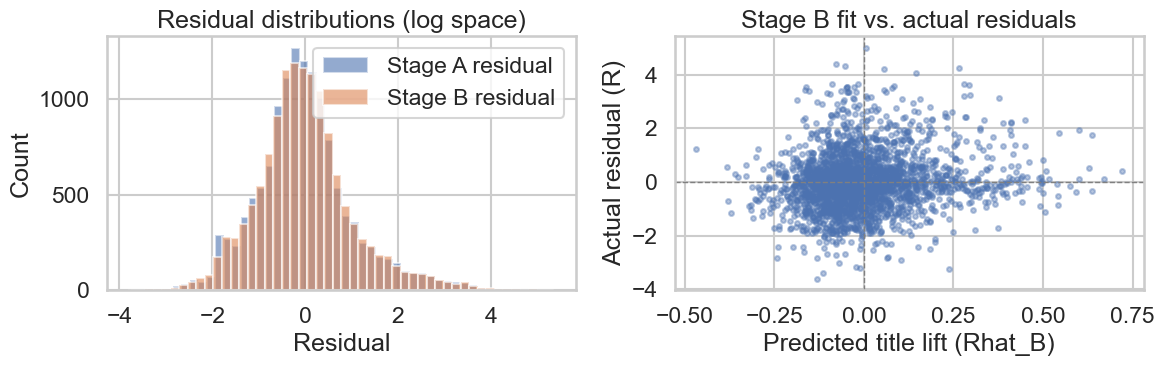

In [52]:

# --- Residual structure visualization ---
sample_size = min(2500, len(df))
sample_df = df.sample(sample_size, random_state=RANDOM_STATE) if len(df) > sample_size else df

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df['R'], bins=50, alpha=0.6, label='Stage A residual')
axes[0].hist(df['stage_b_residual'], bins=50, alpha=0.6, label='Stage B residual')
axes[0].set_title('Residual distributions (log space)')
axes[0].set_xlabel('Residual')
axes[0].set_ylabel('Count')
axes[0].legend()

axes[1].scatter(sample_df['title_lift_component'], sample_df['R'], s=12, alpha=0.4)
axes[1].axhline(0, color='gray', linewidth=1, linestyle='--')
axes[1].axvline(0, color='gray', linewidth=1, linestyle='--')
axes[1].set_title('Stage B fit vs. actual residuals')
axes[1].set_xlabel('Predicted title lift (Rhat_B)')
axes[1].set_ylabel('Actual residual (R)')

plt.tight_layout()
plt.show()

### Expanded Residual Diagnostics
Augment the quick residual histogram with distributional and structure checks so we can justify model assumptions in presentations.

c:\Users\patri\OneDrive\Documents\RowanMastersClassesFiles\DataMining1\FinalProject\.venv\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


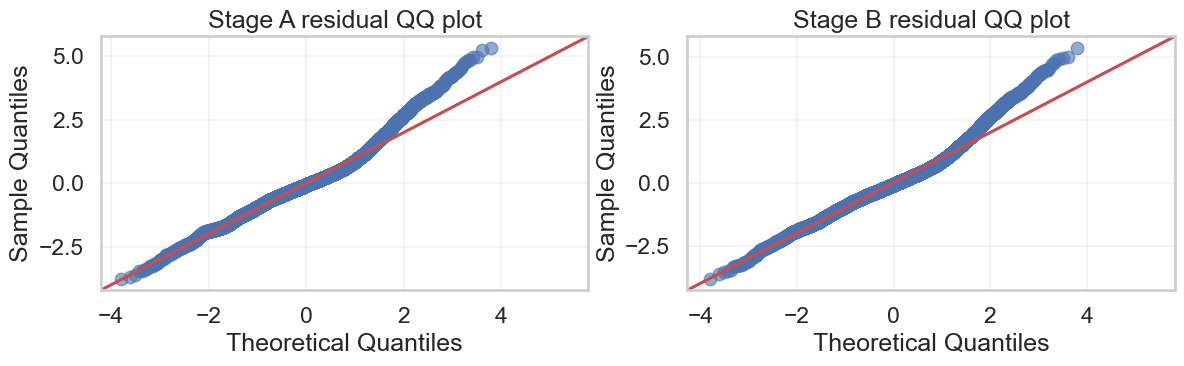

In [53]:
# --- QQ plots for residual normality ---
stage_a_resid = df['R'].dropna()
stage_b_resid = df['stage_b_residual'].dropna()
if stage_a_resid.empty or stage_b_resid.empty:
    raise ValueError('Stage A or Stage B residuals missing; run earlier modeling cells first.')
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sm.ProbPlot(stage_a_resid).qqplot(ax=axes[0], line='45', alpha=0.6, color='#1f77b4')
axes[0].set_title('Stage A residual QQ plot')
axes[0].grid(alpha=0.2)
sm.ProbPlot(stage_b_resid).qqplot(ax=axes[1], line='45', alpha=0.6, color='#ff7f0e')
axes[1].set_title('Stage B residual QQ plot')
axes[1].grid(alpha=0.2)
plt.tight_layout()
plt.show()

#### Residuals vs. fitted values
Visualize whether either stage leaves systematic structure across the fitted range or exposure bands.

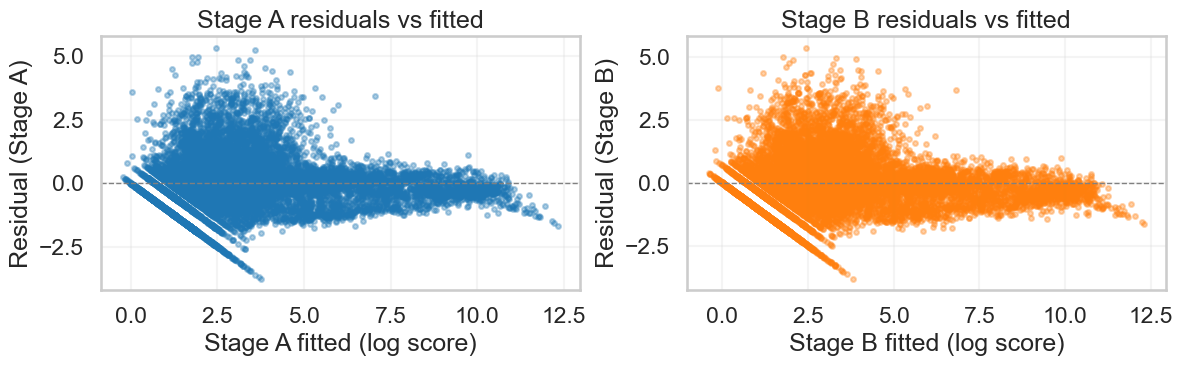

In [54]:
# --- Residuals vs fitted values ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(df['yhat_A'], df['R'], s=12, alpha=0.35, color='#1f77b4')
axes[0].axhline(0, color='gray', linewidth=1, linestyle='--')
axes[0].set_title('Stage A residuals vs fitted')
axes[0].set_xlabel('Stage A fitted (log score)')
axes[0].set_ylabel('Residual (Stage A)')
axes[0].grid(alpha=0.2)
axes[1].scatter(df['stage_b_prediction'], df['stage_b_residual'], s=12, alpha=0.35, color='#ff7f0e')
axes[1].axhline(0, color='gray', linewidth=1, linestyle='--')
axes[1].set_title('Stage B residuals vs fitted')
axes[1].set_xlabel('Stage B fitted (log score)')
axes[1].set_ylabel('Residual (Stage B)')
axes[1].grid(alpha=0.2)
plt.tight_layout()
plt.show()

#### Temporal and platform residual patterns
Check whether residuals cluster by posting hour or platform, which would hint at remaining exposure bias.

C:\Users\patri\AppData\Local\Temp\ipykernel_27540\1374182358.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(box_data, labels=top_platforms, patch_artist=True, boxprops=dict(facecolor='#ffbb78', alpha=0.7))


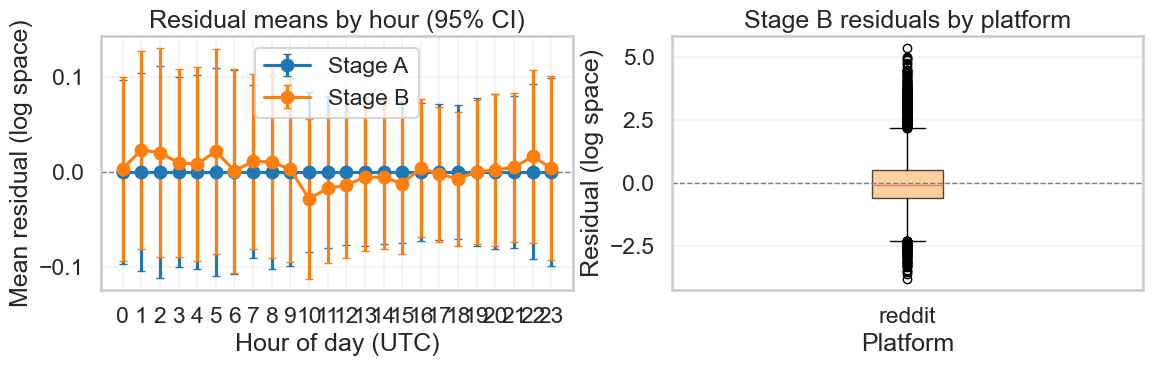

In [55]:
# --- Temporal and platform checks ---
hourly = (
    df.dropna(subset=['hour_of_day'])
      .groupby('hour_of_day')
      .agg(stage_a_mean=('R', 'mean'),
           stage_a_std=('R', 'std'),
           stage_b_mean=('stage_b_residual', 'mean'),
           stage_b_std=('stage_b_residual', 'std'),
           n=('R', 'size'))
      .reset_index()
      .sort_values('hour_of_day')
)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
if hourly.empty:
    axes[0].text(0.5, 0.5, 'hour_of_day not available', ha='center', va='center')
    axes[0].set_axis_off()
else:
    counts = hourly['n'].clip(lower=1)
    hourly['stage_a_ci'] = 1.96 * hourly['stage_a_std'] / np.sqrt(counts)
    hourly['stage_b_ci'] = 1.96 * hourly['stage_b_std'] / np.sqrt(counts)
    axes[0].errorbar(hourly['hour_of_day'], hourly['stage_a_mean'], yerr=hourly['stage_a_ci'], fmt='o-', capsize=3, label='Stage A', color='#1f77b4')
    axes[0].errorbar(hourly['hour_of_day'], hourly['stage_b_mean'], yerr=hourly['stage_b_ci'], fmt='o-', capsize=3, label='Stage B', color='#ff7f0e')
    axes[0].axhline(0, color='gray', linewidth=1, linestyle='--')
    axes[0].set_title('Residual means by hour (95% CI)')
    axes[0].set_xlabel('Hour of day (UTC)')
    axes[0].set_ylabel('Mean residual (log space)')
    axes[0].set_xticks(sorted(hourly['hour_of_day'].unique()))
    axes[0].grid(alpha=0.2)
    axes[0].legend()
platform_counts = df['platform'].value_counts()
top_platforms = platform_counts[platform_counts >= 100].index.tolist()
platform_plot = df[df['platform'].isin(top_platforms)]
if platform_plot.empty:
    axes[1].text(0.5, 0.5, 'Insufficient platform volume for boxplot', ha='center', va='center')
    axes[1].set_axis_off()
else:
    box_data = [platform_plot.loc[platform_plot['platform'] == platform, 'stage_b_residual'].dropna() for platform in top_platforms]
    axes[1].boxplot(box_data, labels=top_platforms, patch_artist=True, boxprops=dict(facecolor='#ffbb78', alpha=0.7))
    axes[1].axhline(0, color='gray', linewidth=1, linestyle='--')
    axes[1].set_title('Stage B residuals by platform')
    axes[1].set_xlabel('Platform')
    axes[1].set_ylabel('Residual (log space)')
    axes[1].grid(alpha=0.2)
plt.tight_layout()
plt.show()


## Optional: Pairwise Ranking Check (Subset)

Construct within-window pairs (e.g., same hour) and test whether:
- **Title-only** model can rank higher-`R` post correctly, and
- **Intrinsic + title** (using `yhat_A + predicted title component`) can do better.

This is optional and can be skipped for time.


In [56]:
# --- Pairwise ranking evaluation ---
PAIRWISE_GROUP_COLS = ['subreddit', 'day_of_week', 'hour_of_day']
PAIRWISE_MAX_GROUP = 30
pairs = []
pairwise_summary = pd.DataFrame()
pairwise_filtered = pd.DataFrame()

model_pred_entries = [
    ('baseline', 'Stage A baseline', 'yhat_A'),
    ('combined', 'Stage A + Stage B (OLS)', 'stage_b_prediction')
 ]

if 'stage_b_prediction_centered' in df.columns:
    model_pred_entries.append(('combined_centered', 'Stage A + Stage B (Centered)', 'stage_b_prediction_centered'))
if 'stage_b_prediction_en' in df.columns:
    model_pred_entries.append(('combined_en', 'Stage A + Stage B (Elastic Net)', 'stage_b_prediction_en'))
if 'stage_b_prediction_lgb' in df.columns:
    model_pred_entries.append(('combined_lgb', 'Stage A + Stage B (LightGBM)', 'stage_b_prediction_lgb'))

title_pred_entries = [
    ('title_only', 'Title residual only (OLS)', 'title_lift_component')
 ]

if 'title_lift_component_centered' in df.columns:
    title_pred_entries.append(('title_only_centered', 'Title residual only (Centered)', 'title_lift_component_centered'))
if 'title_lift_component_en' in df.columns:
    title_pred_entries.append(('title_only_en', 'Title residual only (Elastic Net)', 'title_lift_component_en'))
if 'title_lift_component_lgb' in df.columns:
    title_pred_entries.append(('title_only_lgb', 'Title residual only (LightGBM)', 'title_lift_component_lgb'))

required_cols = {'y', 'R'}
required_cols.update(entry[2] for entry in model_pred_entries)
required_cols.update(entry[2] for entry in title_pred_entries)

for key, group in df.groupby(PAIRWISE_GROUP_COLS):
    group = group.dropna(subset=list(required_cols))
    if len(group) < 2:
        continue
    if len(group) > PAIRWISE_MAX_GROUP:
        group = group.sample(PAIRWISE_MAX_GROUP, random_state=RANDOM_STATE)
    values = {col: group[col].to_numpy() for col in required_cols}
    subreddit, day_of_week, hour_of_day = key
    for i, j in combinations(range(len(group)), 2):
        actual_diff = values['y'][i] - values['y'][j]
        if np.isclose(actual_diff, 0.0):
            continue
        record = {
            'subreddit': subreddit,
            'day_of_week': int(day_of_week),
            'hour_of_day': int(hour_of_day),
            'actual_sign': np.sign(actual_diff)
        }
        for key_name, _, col_name in model_pred_entries:
            record[f'{key_name}_sign'] = np.sign(values[col_name][i] - values[col_name][j])
        for key_name, _, col_name in title_pred_entries:
            record[f'{key_name}_sign'] = np.sign(values[col_name][i] - values[col_name][j])
        pairs.append(record)

pairwise_df = pd.DataFrame(pairs)

if pairwise_df.empty:
    print('No eligible pairs generated. Ensure groups contain at least two posts.')
else:
    filtered_pairs = pairwise_df[pairwise_df['actual_sign'] != 0].copy()
    if filtered_pairs.empty:
        print('All candidate pairs were ties on the outcome metric.')
    else:
        pairwise_filtered = filtered_pairs
        for key_name, _, _ in model_pred_entries + title_pred_entries:
            col = f'{key_name}_sign'
            if col in filtered_pairs.columns:
                filtered_pairs[f'{key_name}_correct'] = (filtered_pairs[col] == filtered_pairs['actual_sign']).astype(float)

        baseline_acc = filtered_pairs['baseline_correct'].mean() if 'baseline_correct' in filtered_pairs else np.nan
        accuracy_rows = []
        for key_name, label, _ in model_pred_entries:
            if f'{key_name}_correct' in filtered_pairs.columns:
                acc = filtered_pairs[f'{key_name}_correct'].mean()
                accuracy_rows.append((label, acc))
        overall_accuracy = pd.DataFrame(accuracy_rows, columns=['model', 'accuracy']).assign(accuracy=lambda d: d['accuracy'].round(4))
        if not overall_accuracy.empty and not np.isnan(baseline_acc):
            overall_accuracy['lift_vs_stage_a'] = (overall_accuracy['accuracy'] - baseline_acc).round(4)
        else:
            overall_accuracy['lift_vs_stage_a'] = np.nan

        title_accuracy_rows = []
        for key_name, label, _ in title_pred_entries:
            if f'{key_name}_correct' in filtered_pairs.columns:
                title_accuracy_rows.append((label, filtered_pairs[f'{key_name}_correct'].mean()))
        title_accuracy = pd.DataFrame(title_accuracy_rows, columns=['model', 'accuracy']).assign(accuracy=lambda d: d['accuracy'].round(4)) if title_accuracy_rows else pd.DataFrame()

        agg_dict = {'pairs': ('actual_sign', 'count')}
        if 'baseline_correct' in filtered_pairs:
            agg_dict['baseline_acc'] = ('baseline_correct', 'mean')
        if 'combined_correct' in filtered_pairs:
            agg_dict['combined_acc'] = ('combined_correct', 'mean')
        if 'combined_centered_correct' in filtered_pairs:
            agg_dict['combined_centered_acc'] = ('combined_centered_correct', 'mean')
        if 'combined_en_correct' in filtered_pairs:
            agg_dict['combined_en_acc'] = ('combined_en_correct', 'mean')
        if 'combined_lgb_correct' in filtered_pairs:
            agg_dict['combined_lgb_acc'] = ('combined_lgb_correct', 'mean')
        if 'title_only_correct' in filtered_pairs:
            agg_dict['title_only_acc'] = ('title_only_correct', 'mean')
        pairwise_summary = filtered_pairs.groupby(PAIRWISE_GROUP_COLS).agg(**agg_dict).reset_index()

        overall_rows = [
            {'metric': 'overall_pairs', 'value': int(filtered_pairs.shape[0])}
        ]
        if not np.isnan(baseline_acc):
            overall_rows.append({'metric': 'baseline_accuracy', 'value': float(baseline_acc)})
        if not overall_accuracy.empty:
            for _, row in overall_accuracy.iterrows():
                overall_rows.append({'metric': f"accuracy_{row['model'].lower().replace(' ', '_')}", 'value': float(row['accuracy'])})
        if not title_accuracy.empty:
            for _, row in title_accuracy.iterrows():
                overall_rows.append({'metric': f"accuracy_{row['model'].lower().replace(' ', '_')}", 'value': float(row['accuracy'])})

        overall_table = pd.DataFrame(overall_rows)
        display(overall_table)

        overall_pairwise = pd.DataFrame(
            [
                {'model': label, 'accuracy': float(acc)} for label, acc in accuracy_rows
            ]
        ) if accuracy_rows else pd.DataFrame()

        target_accuracy = 0.60
        if overall_pairwise.empty:
            print('No model accuracy rows constructed; rerun with more data.')
        else:
            print(f'Overall Stage B pairwise accuracy (vs Stage A baseline):')
            display(overall_pairwise)
            print(f'Pairwise lift vs Stage A baseline:')
            display(overall_pairwise.assign(lift_vs_stage_a=lambda d: (d['accuracy'] - baseline_acc).round(4)))

        if not title_accuracy.empty:
            print('Title-only pairwise accuracy:')
            display(title_accuracy)

        agg_kwargs = {
            'accuracy_mean': ('baseline_correct', 'mean'),
            'combined_accuracy_mean': ('combined_correct', 'mean') if 'combined_correct' in filtered_pairs else ('baseline_correct', 'mean'),
            'pair_count': ('actual_sign', 'count')
        }
        grouped_pairs_summary = filtered_pairs.groupby('subreddit').agg(**agg_kwargs).reset_index()
        grouped_pairs_summary = grouped_pairs_summary.sort_values('pair_count', ascending=False)
        print('Top subreddits by pairwise volume:')
        display(grouped_pairs_summary.head(10))

        if not pairwise_summary.empty:
            display(pairwise_summary.head(10))

        if 'combined_correct' in filtered_pairs:
            comparison = filtered_pairs[['combined_correct', 'baseline_correct']].mean()
            print('Combined vs baseline accuracy:')
            print(comparison)


,metric,value
0,overall_pairs,81002.000000
1,baseline_accuracy,0.827856
2,accuracy_stage_a_baseline,0.827900
3,accuracy_stage_a_+_stage_b_(ols),0.830300
4,accuracy_stage_a_+_stage_b_(centered),0.830300
5,accuracy_stage_a_+_stage_b_(elastic_net),0.831300
6,accuracy_stage_a_+_stage_b_(lightgbm),0.870000
7,accuracy_title_residual_only_(ols),0.572800
8,accuracy_title_residual_only_(centered),0.572800
9,accuracy_title_residual_only_(elastic_net),0.571800


Overall Stage B pairwise accuracy (vs Stage A baseline):


,model,accuracy
0,Stage A baseline,0.827856
1,Stage A + Stage B (OLS),0.830300
2,Stage A + Stage B (Centered),0.830300
3,Stage A + Stage B (Elastic Net),0.831313
4,Stage A + Stage B (LightGBM),0.869954


Pairwise lift vs Stage A baseline:


,model,accuracy,lift_vs_stage_a
0,Stage A baseline,0.827856,0.0000
1,Stage A + Stage B (OLS),0.830300,0.0024
2,Stage A + Stage B (Centered),0.830300,0.0024
3,Stage A + Stage B (Elastic Net),0.831313,0.0035
4,Stage A + Stage B (LightGBM),0.869954,0.0421


Title-only pairwise accuracy:


,model,accuracy
0,Title residual only (OLS),0.5728
1,Title residual only (Centered),0.5728
2,Title residual only (Elastic Net),0.5718
3,Title residual only (LightGBM),0.6584


Top subreddits by pairwise volume:


,subreddit,accuracy_mean,combined_accuracy_mean,pair_count
5,politics,0.816046,0.816441,43027
10,worldnews,0.801806,0.803083,10964
9,technology,0.863184,0.871663,9553
2,economy,0.798408,0.805331,8666
6,science,0.882865,0.878993,2066
7,space,0.925703,0.934237,1992
0,Futurology,0.920130,0.925325,1540
3,energy,0.919463,0.920955,1341
8,technews,0.899020,0.900980,1020
1,business,0.906767,0.906767,665


,subreddit,day_of_week,hour_of_day,pairs,baseline_acc,combined_acc,combined_centered_acc,combined_en_acc,combined_lgb_acc,title_only_acc
0,Futurology,0,0,22,0.954545,1.000000,1.000000,1.000000,1.000000,0.772727
1,Futurology,0,1,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,Futurology,0,2,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,Futurology,0,3,1,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
4,Futurology,0,7,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,Futurology,0,9,3,1.000000,1.000000,1.000000,1.000000,0.666667,0.333333
6,Futurology,0,10,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,Futurology,0,11,6,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333
8,Futurology,0,12,6,1.000000,1.000000,1.000000,1.000000,1.000000,0.833333
9,Futurology,0,13,3,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667


Combined vs baseline accuracy:
combined_correct    0.830300
baseline_correct    0.827856
dtype: float64


In [57]:
# --- Pairwise drill-down and visuals ---
if pairwise_filtered.empty or pairwise_summary.empty:
    print('Pairwise summary unavailable because no pairs were generated.')
else:
    min_pairs = 30
    filtered_subs = pairwise_summary[pairwise_summary['pairs'] >= min_pairs].copy()
    if filtered_subs.empty:
        print(f'No subreddit buckets with ≥{min_pairs} pairs; consider lowering the threshold.')
    else:
        top_lift = filtered_subs.sort_values('lift_combined_vs_baseline', ascending=False).head(10) if 'lift_combined_vs_baseline' in filtered_subs else pd.DataFrame()
        bottom_lift = filtered_subs.sort_values('lift_combined_vs_baseline', ascending=True).head(10) if 'lift_combined_vs_baseline' in filtered_subs else pd.DataFrame()

        if not top_lift.empty:
            print(f'Top {len(top_lift)} subreddit buckets by combined-model lift (OLS, ≥{min_pairs} pairs):')
            display(top_lift[['subreddit', 'pairs', 'baseline_acc', 'combined_acc', 'lift_combined_vs_baseline']])
        if not bottom_lift.empty:
            print(f'Bottom {len(bottom_lift)} subreddit buckets by combined-model lift (OLS, ≥{min_pairs} pairs):')
            display(bottom_lift[['subreddit', 'pairs', 'baseline_acc', 'combined_acc', 'lift_combined_vs_baseline']])

        if 'lift_combined_centered_vs_baseline' in filtered_subs:
            top_lift_centered = filtered_subs.sort_values('lift_combined_centered_vs_baseline', ascending=False).head(10)
            bottom_lift_centered = filtered_subs.sort_values('lift_combined_centered_vs_baseline', ascending=True).head(10)
            print(f'Top {len(top_lift_centered)} subreddit buckets by centered-model lift (≥{min_pairs} pairs):')
            display(top_lift_centered[['subreddit', 'pairs', 'baseline_acc', 'combined_centered_acc', 'lift_combined_centered_vs_baseline']])
            print(f'Bottom {len(bottom_lift_centered)} subreddit buckets by centered-model lift (≥{min_pairs} pairs):')
            display(bottom_lift_centered[['subreddit', 'pairs', 'baseline_acc', 'combined_centered_acc', 'lift_combined_centered_vs_baseline']])

        if 'lift_combined_en_vs_baseline' in filtered_subs:
            top_lift_en = filtered_subs.sort_values('lift_combined_en_vs_baseline', ascending=False).head(10)
            bottom_lift_en = filtered_subs.sort_values('lift_combined_en_vs_baseline', ascending=True).head(10)
            print(f'Top {len(top_lift_en)} subreddit buckets by Elastic Net lift (≥{min_pairs} pairs):')
            display(top_lift_en[['subreddit', 'pairs', 'baseline_acc', 'combined_en_acc', 'lift_combined_en_vs_baseline']])
            print(f'Bottom {len(bottom_lift_en)} subreddit buckets by Elastic Net lift (≥{min_pairs} pairs):')
            display(bottom_lift_en[['subreddit', 'pairs', 'baseline_acc', 'combined_en_acc', 'lift_combined_en_vs_baseline']])

        if 'lift_combined_lgb_vs_baseline' in filtered_subs:
            top_lift_lgb = filtered_subs.sort_values('lift_combined_lgb_vs_baseline', ascending=False).head(10)
            bottom_lift_lgb = filtered_subs.sort_values('lift_combined_lgb_vs_baseline', ascending=True).head(10)
            print(f'Top {len(top_lift_lgb)} subreddit buckets by LightGBM lift (≥{min_pairs} pairs):')
            display(top_lift_lgb[['subreddit', 'pairs', 'baseline_acc', 'combined_lgb_acc', 'lift_combined_lgb_vs_baseline']])
            print(f'Bottom {len(bottom_lift_lgb)} subreddit buckets by LightGBM lift (≥{min_pairs} pairs):')
            display(bottom_lift_lgb[['subreddit', 'pairs', 'baseline_acc', 'combined_lgb_acc', 'lift_combined_lgb_vs_baseline']])

        agg_kwargs = {
            'pairs': ('pair', 'sum'),
            'baseline_acc': ('baseline_correct', 'mean')
        }
        if 'combined_correct' in pairwise_filtered.columns:
            agg_kwargs['combined_acc'] = ('combined_correct', 'mean')
        if 'combined_centered_correct' in pairwise_filtered.columns:
            agg_kwargs['combined_centered_acc'] = ('combined_centered_correct', 'mean')
        if 'combined_en_correct' in pairwise_filtered.columns:
            agg_kwargs['combined_en_acc'] = ('combined_en_correct', 'mean')
        if 'combined_lgb_correct' in pairwise_filtered.columns:
            agg_kwargs['combined_lgb_acc'] = ('combined_lgb_correct', 'mean')

        hour_summary = (
            pairwise_filtered.assign(pair=1)
                           .groupby(['day_of_week', 'hour_of_day'])
                           .agg(**agg_kwargs)
                           .reset_index()
        )
        hour_summary['baseline_acc'] = hour_summary['baseline_acc'].round(4)
        if 'combined_acc' in hour_summary.columns:
            hour_summary['combined_acc'] = hour_summary['combined_acc'].round(4)
            hour_summary['lift'] = (hour_summary['combined_acc'] - hour_summary['baseline_acc']).round(4)
        if 'combined_centered_acc' in hour_summary.columns:
            hour_summary['combined_centered_acc'] = hour_summary['combined_centered_acc'].round(4)
            hour_summary['lift_centered'] = (hour_summary['combined_centered_acc'] - hour_summary['baseline_acc']).round(4)
        if 'combined_en_acc' in hour_summary.columns:
            hour_summary['combined_en_acc'] = hour_summary['combined_en_acc'].round(4)
            hour_summary['lift_en'] = (hour_summary['combined_en_acc'] - hour_summary['baseline_acc']).round(4)
        if 'combined_lgb_acc' in hour_summary.columns:
            hour_summary['combined_lgb_acc'] = hour_summary['combined_lgb_acc'].round(4)
            hour_summary['lift_lgb'] = (hour_summary['combined_lgb_acc'] - hour_summary['baseline_acc']).round(4)
        print('Day/hour lift table (first 12 rows, OLS variant plus comparisons):')
        display(hour_summary.sort_values('pairs', ascending=False).head(12))

        if not top_lift.empty:
            top_plot = top_lift.sort_values('lift_combined_vs_baseline', ascending=True)
            fig, ax = plt.subplots(figsize=(8, 5))
            ax.barh(top_plot['subreddit'], top_plot['lift_combined_vs_baseline'], color='#1f77b4')
            ax.set_xlabel('Lift vs Stage A baseline (accuracy)')
            ax.set_ylabel('Subreddit')
            ax.set_title('Pairwise ranking lift by subreddit (OLS top 10)')
            plt.tight_layout()
            plt.show()

Day/hour lift table (first 12 rows, OLS variant plus comparisons):


,day_of_week,hour_of_day,pairs,baseline_acc,combined_acc,combined_centered_acc,combined_en_acc,combined_lgb_acc,lift,lift_centered,lift_en,lift_lgb
112,4,16,1257,0.8496,0.8512,0.8512,0.8496,0.8807,0.0016,0.0016,0.0000,0.0311
18,0,18,1114,0.8671,0.8734,0.8734,0.8698,0.8860,0.0063,0.0063,0.0027,0.0189
111,4,15,1064,0.8224,0.8308,0.8308,0.8271,0.8731,0.0084,0.0084,0.0047,0.0507
37,1,13,1036,0.8060,0.8166,0.8166,0.8166,0.8533,0.0106,0.0106,0.0106,0.0473
114,4,18,1032,0.8585,0.8595,0.8595,0.8682,0.8924,0.0010,0.0010,0.0097,0.0339
109,4,13,1028,0.8405,0.8356,0.8356,0.8385,0.8765,-0.0049,-0.0049,-0.0020,0.0360
16,0,16,983,0.7986,0.7996,0.7996,0.7955,0.8454,0.0010,0.0010,-0.0031,0.0468
36,1,12,978,0.8139,0.8292,0.8292,0.8241,0.8753,0.0153,0.0153,0.0102,0.0614
64,2,16,967,0.8221,0.8345,0.8345,0.8273,0.8862,0.0124,0.0124,0.0052,0.0641
86,3,14,959,0.8332,0.8373,0.8373,0.8363,0.8801,0.0041,0.0041,0.0031,0.0469


In [58]:

# --- Load diagnostics artifacts ---
diag_dir = PROJECT_ROOT / 'docs' / 'diagnostics'
temporal_df = blocked_df = bootstrap_summary_df = learning_curve_df = None

if not diag_dir.exists():
    print(f'Diagnostics directory not found at {diag_dir}')
else:
    temporal_path = diag_dir / 'stage_model_temporal_splits.csv'
    blocked_path = diag_dir / 'stage_model_blocked_cv.csv'
    bootstrap_summary_path = diag_dir / 'stage_model_bootstrap_summary.csv'
    learning_curve_path = diag_dir / 'stage_model_learning_curve.csv'

    if temporal_path.exists():
        temporal_df = pd.read_csv(temporal_path)
        temporal_df['split_time'] = pd.to_datetime(temporal_df['split_time'], errors='coerce')
        temporal_df['stage_b_gain_rmse'] = (temporal_df['stage_a_test_rmse'] - temporal_df['stage_b_test_rmse']).round(4)
    else:
        print('Temporal splits diagnostic not found.')

    if blocked_path.exists():
        blocked_df = pd.read_csv(blocked_path, parse_dates=['block_start', 'block_end'])
        blocked_df['stage_b_gain_rmse'] = (blocked_df['stage_a_test_rmse'] - blocked_df['stage_b_test_rmse']).round(4)
    else:
        print('Blocked CV diagnostic not found.')

    if bootstrap_summary_path.exists():
        bootstrap_raw = pd.read_csv(bootstrap_summary_path)
        bootstrap_summary_df = bootstrap_raw.copy()
        bootstrap_summary_df['point_estimate'] = bootstrap_summary_df['value']
        bootstrap_summary_df.loc[bootstrap_summary_df['point_estimate'].isna(), 'point_estimate'] = bootstrap_summary_df.loc[bootstrap_summary_df['point_estimate'].isna(), 'mean']
        bootstrap_summary_df = bootstrap_summary_df[['metric', 'point_estimate', 'mean', 'std']].rename(columns={'mean': 'bootstrap_mean', 'std': 'bootstrap_std'})
    else:
        print('Bootstrap summary diagnostic not found.')

    if learning_curve_path.exists():
        learning_curve_df = pd.read_csv(learning_curve_path)
        learning_curve_df['stage_b_gain_rmse'] = (learning_curve_df['stage_a_test_rmse'] - learning_curve_df['stage_b_test_rmse']).round(4)
    else:
        print('Learning-curve diagnostic not found.')

In [59]:

# --- Diagnostics tables ---
if temporal_df is not None and not temporal_df.empty:
    temporal_table = (
        temporal_df[['split_quantile', 'split_time', 'stage_a_test_rmse', 'stage_b_test_rmse', 'stage_b_gain_rmse', 'stage_a_gap_rmse', 'stage_b_gap_rmse']]
        .rename(columns={
            'split_quantile': 'quantile',
            'split_time': 'split_time_utc',
            'stage_a_test_rmse': 'stage_a_test_rmse',
            'stage_b_test_rmse': 'stage_b_test_rmse',
            'stage_b_gain_rmse': 'stage_b_gain_rmse',
            'stage_a_gap_rmse': 'stage_a_train_test_gap',
            'stage_b_gap_rmse': 'stage_b_train_test_gap'
        })
        .assign(split_time_utc=lambda d: d['split_time_utc'].dt.strftime('%Y-%m-%d'))
        .round({
            'stage_a_test_rmse': 4,
            'stage_b_test_rmse': 4,
            'stage_b_gain_rmse': 4,
            'stage_a_train_test_gap': 4,
            'stage_b_train_test_gap': 4
        })
    )
    print('Temporal splits (Stage B consistently reduces RMSE across holdout quantiles):')
    display(temporal_table)
else:
    print('Temporal splits table unavailable.')

if blocked_df is not None and not blocked_df.empty:
    blocked_view = (
        blocked_df[['block', 'stage_a_test_rmse', 'stage_b_test_rmse', 'stage_b_gain_rmse', 'stage_a_gap_rmse', 'stage_b_gap_rmse']]
        .rename(columns={
            'stage_a_gap_rmse': 'stage_a_train_test_gap',
            'stage_b_gap_rmse': 'stage_b_train_test_gap'
        })
        .round(4)
    )
    top_blocks = blocked_view.sort_values('stage_b_gain_rmse', ascending=False).head(5)
    bottom_blocks = blocked_view.sort_values('stage_b_gain_rmse', ascending=True).head(5)
    print('Blocked CV – strongest positive Stage B gains:')
    display(top_blocks)
    print('Blocked CV – weakest or negative Stage B gains:')
    display(bottom_blocks)
else:
    print('Blocked CV table unavailable.')

if bootstrap_summary_df is not None and not bootstrap_summary_df.empty:
    print('Bootstrap summary (trimmed mean across 30 resamples):')
    display(bootstrap_summary_df)
else:
    print('Bootstrap summary unavailable.')

Temporal splits (Stage B consistently reduces RMSE across holdout quantiles):


,quantile,split_time_utc,stage_a_test_rmse,stage_b_test_rmse,stage_b_gain_rmse,stage_a_train_test_gap,stage_b_train_test_gap
0,0.60,2025-11-10,1.2222,1.2222,0.0000,0.3097,0.3097
1,0.65,2025-11-11,1.1855,1.1786,0.0069,0.2418,0.2389
2,0.70,2025-11-12,1.1900,1.1827,0.0073,0.2330,0.2300
3,0.75,2025-11-12,1.1996,1.1897,0.0099,0.2324,0.2281
4,0.80,2025-11-13,1.2058,1.1962,0.0096,0.2274,0.2236


Blocked CV – strongest positive Stage B gains:


,block,stage_a_test_rmse,stage_b_test_rmse,stage_b_gain_rmse,stage_a_train_test_gap,stage_b_train_test_gap
1,2025-11-06,1.4431,1.3471,0.0960,0.7709,0.6748
2,2025-11-07,1.3572,1.3040,0.0531,0.5945,0.5414
8,2025-11-13,1.1832,1.1403,0.0429,0.2163,0.1790
6,2025-11-11,1.1450,1.1182,0.0268,0.2018,0.1789
3,2025-11-08,1.5321,1.5064,0.0257,0.7129,0.6873


Blocked CV – weakest or negative Stage B gains:


,block,stage_a_test_rmse,stage_b_test_rmse,stage_b_gain_rmse,stage_a_train_test_gap,stage_b_train_test_gap
4,2025-11-09,1.3268,1.3723,-0.0455,0.4520,0.4975
11,2025-11-16,1.2368,1.2530,-0.0161,0.2336,0.2549
5,2025-11-10,1.3626,1.3626,-0.0000,0.4544,0.4544
0,2025-11-05,5.1583,5.1537,0.0046,4.6725,4.6679
7,2025-11-12,1.1038,1.0968,0.0069,0.1469,0.1443


Bootstrap summary (trimmed mean across 30 resamples):


,metric,point_estimate,bootstrap_mean,bootstrap_std
0,iterations,30.000000,NaN,NaN
1,trim_fraction,0.100000,NaN,NaN
2,stage_a_train_rmse,1.023855,1.023855,0.007681
3,stage_a_test_rmse,1.018785,1.018785,0.007842
4,stage_b_train_rmse,1.013715,1.013715,0.007722
5,stage_b_test_rmse,1.011209,1.011209,0.008011
6,stage_b_test_r2,0.014685,0.014685,0.003160
7,pairwise_accuracy,0.540686,0.540686,0.005911


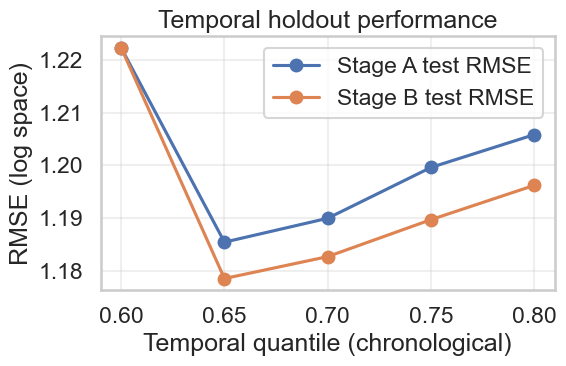

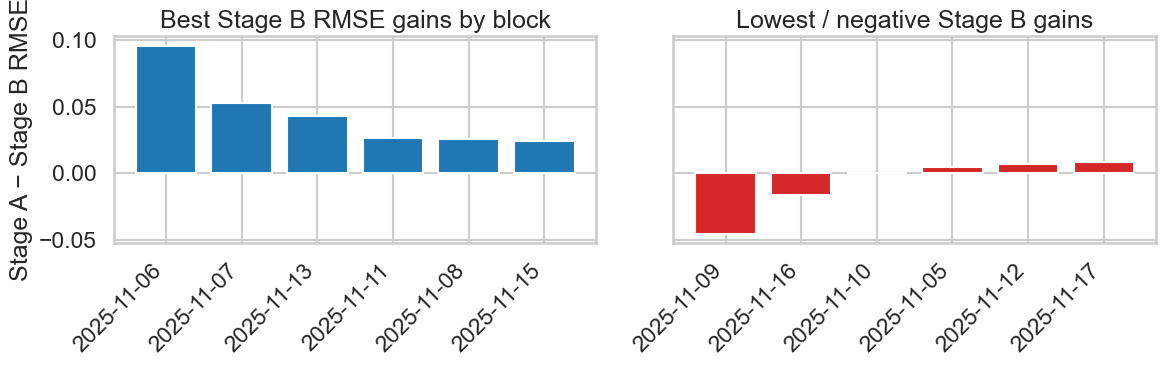

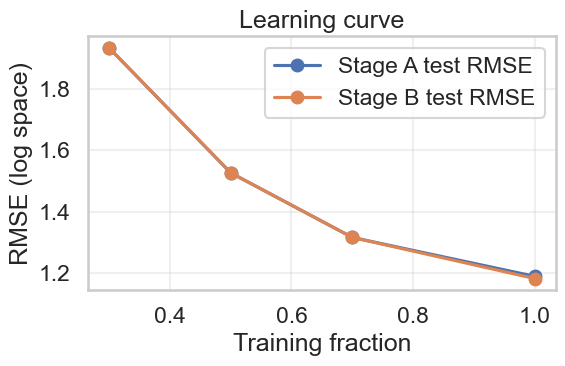

In [60]:

# --- Diagnostics figures ---
if temporal_df is not None and not temporal_df.empty:
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(temporal_df['split_quantile'], temporal_df['stage_a_test_rmse'], marker='o', label='Stage A test RMSE')
    ax.plot(temporal_df['split_quantile'], temporal_df['stage_b_test_rmse'], marker='o', label='Stage B test RMSE')
    ax.set_xlabel('Temporal quantile (chronological)')
    ax.set_ylabel('RMSE (log space)')
    ax.set_title('Temporal holdout performance')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print('Temporal diagnostics figure unavailable.')

if blocked_df is not None and not blocked_df.empty:
    block_gain = blocked_df[['block', 'stage_b_gain_rmse']].sort_values('stage_b_gain_rmse', ascending=False)
    top_blocks = block_gain.head(6)
    worst_blocks = block_gain.tail(6).sort_values('stage_b_gain_rmse')
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    top_pos = np.arange(len(top_blocks))
    worst_pos = np.arange(len(worst_blocks))
    axes[0].bar(top_pos, top_blocks['stage_b_gain_rmse'], color='#1f77b4')
    axes[0].set_title('Best Stage B RMSE gains by block')
    axes[0].set_ylabel('Stage A − Stage B RMSE')
    axes[0].set_xticks(top_pos)
    axes[0].set_xticklabels(top_blocks['block'], rotation=45, ha='right')
    axes[1].bar(worst_pos, worst_blocks['stage_b_gain_rmse'], color='#d62728')
    axes[1].set_title('Lowest / negative Stage B gains')
    axes[1].set_xticks(worst_pos)
    axes[1].set_xticklabels(worst_blocks['block'], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print('Blocked diagnostics figure unavailable.')

if learning_curve_df is not None and not learning_curve_df.empty:
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(learning_curve_df['fraction'], learning_curve_df['stage_a_test_rmse'], marker='o', label='Stage A test RMSE')
    ax.plot(learning_curve_df['fraction'], learning_curve_df['stage_b_test_rmse'], marker='o', label='Stage B test RMSE')
    ax.set_xlabel('Training fraction')
    ax.set_ylabel('RMSE (log space)')
    ax.set_title('Learning curve')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print('Learning-curve figure unavailable.')

In [61]:

# ----Tables----- 
import json
from pathlib import Path

metrics = stage_summary.set_index('metric')['value']

row_metric_map = {
    'RMSE (log space)': {
        'Stage A baseline': 'Stage A RMSE (log space)',
        'Stage B (OLS)': 'Stage B RMSE (log space)',
        'Stage B (Elastic Net)': 'Stage B (Elastic Net) RMSE (log space)',
        'Stage B (LightGBM)': 'Stage B (LightGBM) RMSE (log space)'
    },
    'MAE (log space)': {
        'Stage A baseline': 'Stage A MAE (log space)',
        'Stage B (OLS)': 'Stage B MAE (log space)',
        'Stage B (Elastic Net)': 'Stage B (Elastic Net) MAE (log space)',
        'Stage B (LightGBM)': 'Stage B (LightGBM) MAE (log space)'
    },
    'Residual std': {
        'Stage A baseline': 'Residual std (Stage A)',
        'Stage B (OLS)': 'Residual std (Stage B)',
        'Stage B (Elastic Net)': 'Residual std (Stage B Elastic Net)',
        'Stage B (LightGBM)': 'Residual std (Stage B LightGBM)'
    }
}

columns_order = ['Stage A baseline', 'Stage B (OLS)']
if 'Stage B (Elastic Net) RMSE (log space)' in metrics.index:
    columns_order.append('Stage B (Elastic Net)')
if 'Stage B (LightGBM) RMSE (log space)' in metrics.index:
    columns_order.append('Stage B (LightGBM)')

overall_rows = []
for row_label, metric_map in row_metric_map.items():
    row_values = {'Metric': row_label}
    for col in columns_order:
        metric_key = metric_map.get(col)
        row_values[col] = metrics.get(metric_key) if metric_key else None
    overall_rows.append(row_values)

overall_table = pd.DataFrame(overall_rows)
if 'Stage A baseline' in overall_table:
    for col in columns_order[1:]:
        gain_col = f'{col} gain'
        overall_table[gain_col] = (overall_table['Stage A baseline'] - overall_table[col]).round(4)
overall_table = overall_table.round(4)
overall_table

,Metric,Stage A baseline,Stage B (OLS),Stage B (Elastic Net),Stage B (LightGBM),Stage B (OLS) gain,Stage B (Elastic Net) gain,Stage B (LightGBM) gain
0,RMSE (log space),1.0593,1.0491,1.0515,0.8697,0.0102,0.0078,0.1896
1,MAE (log space),0.7787,0.7771,0.7762,0.6398,0.0016,0.0025,0.1389
2,Residual std,1.0593,1.0492,1.0515,0.8697,0.0101,0.0078,0.1896


In [62]:
# Table 2: Top title lift coefficients (absolute magnitude)
feature_table = (
    coef_B.assign(feature=lambda d: d.index)
          .loc[lambda d: d['feature'] != 'Intercept']
          .assign(abs_coef=lambda d: d['coef'].abs())
          .sort_values('abs_coef', ascending=False)
          .head(10)
          .reset_index(drop=True)
          [['feature', 'coef', 'se', 'abs_coef']]
 )
print('Stage B (OLS) coefficients — top 10 by |coef|:')
display(feature_table)

if 'coef_B_centered' in globals():
    centered_table = (
        coef_B_centered.rename(columns={'coef_centered': 'coef', 'se_centered': 'se'})
                       .assign(feature=lambda d: d.index)
                       .loc[lambda d: d['feature'] != 'Intercept']
                       .assign(abs_coef=lambda d: d['coef'].abs())
                       .sort_values('abs_coef', ascending=False)
                       .head(10)
                       .reset_index(drop=True)
                       [['feature', 'coef', 'se', 'abs_coef']]
    )
    print('Stage B (Centered) coefficients — top 10 by |coef|:')
    display(centered_table)

if 'en_coef' in globals():
    elastic_net_table = en_coef[['feature', 'coef', 'abs_coef']].head(10).reset_index(drop=True)
    print('Stage B (Elastic Net) coefficients — top 10 by |coef|:')
    display(elastic_net_table)

if 'shap_importance' in globals() and shap_importance is not None:
    shap_table = shap_importance.head(10).reset_index(drop=True)
    print('Stage B (LightGBM) SHAP importance — top 10 features:')
    display(shap_table)

Stage B (OLS) coefficients — top 10 by |coef|:


,feature,coef,se,abs_coef
0,sentiment_neutral,-117.616228,42.182787,117.616228
1,sentiment_negative,-117.574220,42.184938,117.574220
2,sentiment_positive,-117.531320,42.179245,117.531320
3,clickbait_patterns,-0.206344,0.192848,0.206344
4,sentiment_compound,-0.169089,0.058360,0.169089
5,has_question,-0.140179,0.036184,0.140179
6,has_exclamation,-0.111322,0.101298,0.111322
7,has_clickbait,0.105977,0.202877,0.105977
8,clickbait_keywords,-0.102825,0.186787,0.102825
9,has_numbers,0.054623,0.034194,0.054623


Stage B (Centered) coefficients — top 10 by |coef|:


,feature,coef,se,abs_coef
0,sentiment_neutral,-117.616228,42.182787,117.616228
1,sentiment_negative,-117.574220,42.184938,117.574220
2,sentiment_positive,-117.531320,42.179245,117.531320
3,clickbait_patterns,-0.206344,0.192848,0.206344
4,sentiment_compound,-0.169089,0.058360,0.169089
5,has_question,-0.140179,0.036184,0.140179
6,has_exclamation,-0.111322,0.101298,0.111322
7,has_clickbait,0.105977,0.202877,0.105977
8,clickbait_keywords,-0.102825,0.186787,0.102825
9,has_numbers,0.054623,0.034194,0.054623


Stage B (Elastic Net) coefficients — top 10 by |coef|:


,feature,coef,abs_coef
0,title_words,0.048278,0.048278
1,title_length,0.035694,0.035694
2,sentiment_compound,-0.031638,0.031638
3,has_question,-0.011235,0.011235
4,sentiment_negative,0.006133,0.006133
5,has_numbers,0.005112,0.005112
6,all_caps_words,-0.002930,0.002930
7,title_chars_per_word,-0.000000,0.000000
8,has_exclamation,-0.000000,0.000000
9,capitalization_ratio,-0.000000,0.000000


Stage B (LightGBM) SHAP importance — top 10 features:


,feature,mean_abs_shap
0,capitalization_ratio,0.062610
1,title_length,0.057612
2,title_words,0.055956
3,sentiment_negative,0.053963
4,title_chars_per_word,0.053278
5,sentiment_compound,0.051636
6,sentiment_neutral,0.034874
7,all_caps_words,0.034173
8,sentiment_positive,0.022975
9,has_question,0.014968


In [63]:
# Table 3: Pairwise ranking accuracy summary
if pairwise_filtered.empty or pairwise_summary.empty:
    print('Pairwise evaluation tables are unavailable because no eligible pairs were generated.')
else:
    baseline_mean = pairwise_filtered['baseline_correct'].mean()
    rows = [('Stage A baseline', baseline_mean)]
    if 'combined_correct' in pairwise_filtered:
        rows.append(('Stage A + Stage B (OLS)', pairwise_filtered['combined_correct'].mean()))
    if 'combined_centered_correct' in pairwise_filtered:
        rows.append(('Stage A + Stage B (Centered)', pairwise_filtered['combined_centered_correct'].mean()))
    if 'combined_en_correct' in pairwise_filtered:
        rows.append(('Stage A + Stage B (Elastic Net)', pairwise_filtered['combined_en_correct'].mean()))
    if 'combined_lgb_correct' in pairwise_filtered:
        rows.append(('Stage A + Stage B (LightGBM)', pairwise_filtered['combined_lgb_correct'].mean()))
    if 'title_only_correct' in pairwise_filtered:
        rows.append(('Title residual only (OLS)', pairwise_filtered['title_only_correct'].mean()))
    if 'title_only_centered_correct' in pairwise_filtered:
        rows.append(('Title residual only (Centered)', pairwise_filtered['title_only_centered_correct'].mean()))
    if 'title_only_en_correct' in pairwise_filtered:
        rows.append(('Title residual only (Elastic Net)', pairwise_filtered['title_only_en_correct'].mean()))
    if 'title_only_lgb_correct' in pairwise_filtered:
        rows.append(('Title residual only (LightGBM)', pairwise_filtered['title_only_lgb_correct'].mean()))
    overall_pairwise = pd.DataFrame(rows, columns=['model', 'accuracy']).assign(accuracy=lambda d: d['accuracy'].round(4))
    overall_pairwise['lift_vs_stage_a'] = (overall_pairwise['accuracy'] - baseline_mean).round(4)
    display(overall_pairwise)
    top_pairwise = pairwise_summary.sort_values('lift_combined_vs_baseline', ascending=False).head(10) if 'lift_combined_vs_baseline' in pairwise_summary else pd.DataFrame()
    bottom_pairwise = pairwise_summary.sort_values('lift_combined_vs_baseline', ascending=True).head(10) if 'lift_combined_vs_baseline' in pairwise_summary else pd.DataFrame()
    if not top_pairwise.empty:
        print('Top subreddit buckets by combined-model lift (min pairs threshold applied earlier):')
        display(top_pairwise[['subreddit', 'pairs', 'baseline_acc', 'combined_acc', 'lift_combined_vs_baseline']])
    if not bottom_pairwise.empty:
        print('Bottom subreddit buckets by combined-model lift:')
        display(bottom_pairwise[['subreddit', 'pairs', 'baseline_acc', 'combined_acc', 'lift_combined_vs_baseline']])
    if 'lift_combined_centered_vs_baseline' in pairwise_summary:
        top_centered = pairwise_summary.sort_values('lift_combined_centered_vs_baseline', ascending=False).head(10)
        bottom_centered = pairwise_summary.sort_values('lift_combined_centered_vs_baseline', ascending=True).head(10)
        print('Top subreddit buckets by centered-model lift:')
        display(top_centered[['subreddit', 'pairs', 'baseline_acc', 'combined_centered_acc', 'lift_combined_centered_vs_baseline']])
        print('Bottom subreddit buckets by centered-model lift:')
        display(bottom_centered[['subreddit', 'pairs', 'baseline_acc', 'combined_centered_acc', 'lift_combined_centered_vs_baseline']])

,model,accuracy,lift_vs_stage_a
0,Stage A baseline,0.8279,0.0000
1,Stage A + Stage B (OLS),0.8303,0.0024
2,Stage A + Stage B (Centered),0.8303,0.0024
3,Stage A + Stage B (Elastic Net),0.8313,0.0034
4,Stage A + Stage B (LightGBM),0.8700,0.0421
5,Title residual only (OLS),0.5728,-0.2551
6,Title residual only (Centered),0.5728,-0.2551
7,Title residual only (Elastic Net),0.5718,-0.2561
8,Title residual only (LightGBM),0.6584,-0.1695


## Success Criteria Check
The success bar is ≥60% pairwise accuracy while preserving calibration.

In [64]:
target_accuracy = 0.60
stage_metrics_lookup = {}
if 'stage_summary' in globals():
    stage_metrics_lookup = stage_summary.set_index('metric')['value'].to_dict()

report_rows = []
for label, metric_key in [
    ("Stage A RMSE (log space)", 'Stage A RMSE (log space)'),
    ("Stage B RMSE (log space)", 'Stage B RMSE (log space)'),
    ("Stage A residual std", 'Residual std (Stage A)'),
    ("Stage B residual std", 'Residual std (Stage B)')
]:
    value = stage_metrics_lookup.get(metric_key)
    if value is not None:
        report_rows.append((label, round(float(value), 4)))

pairwise_rows = []
if 'overall_pairwise' in globals():
    pairwise_rows = [(row['model'], row['accuracy']) for _, row in overall_pairwise.iterrows()]
elif 'pairwise_filtered' in globals() and not pairwise_filtered.empty:
    baseline_mean = pairwise_filtered['baseline_correct'].mean()
    pairwise_rows.append(('Stage A baseline', baseline_mean))
    if 'combined_correct' in pairwise_filtered:
        pairwise_rows.append(('Stage A + Stage B (OLS)', pairwise_filtered['combined_correct'].mean()))
    if 'combined_en_correct' in pairwise_filtered:
        pairwise_rows.append(('Stage A + Stage B (Elastic Net)', pairwise_filtered['combined_en_correct'].mean()))
    if 'combined_lgb_correct' in pairwise_filtered:
        pairwise_rows.append(('Stage A + Stage B (LightGBM)', pairwise_filtered['combined_lgb_correct'].mean()))

if report_rows:
    print("Stage-level metrics:")
    display(pd.DataFrame(report_rows, columns=['metric', 'value']))
else:
    print("Stage metrics unavailable; ensure diagnostics cell executed.")

if pairwise_rows:
    pairwise_table = pd.DataFrame(pairwise_rows, columns=['model', 'pairwise_accuracy']).assign(pairwise_accuracy=lambda d: d['pairwise_accuracy'].round(4))
    pairwise_table['meets_target'] = pairwise_table['pairwise_accuracy'] >= target_accuracy
    print(f"Pairwise accuracy vs. {target_accuracy:.0%} target:")
    display(pairwise_table)
    best_accuracy = pairwise_table['pairwise_accuracy'].max()
    print(f"Best observed pairwise accuracy: {best_accuracy:.3f} ({'passes' if best_accuracy >= target_accuracy else 'below'} target)")
else:
    print("Pairwise evaluation unavailable; rerun pairwise cells if needed.")

Stage-level metrics:


,metric,value
0,Stage A RMSE (log space),1.0593
1,Stage B RMSE (log space),1.0491
2,Stage A residual std,1.0593
3,Stage B residual std,1.0492


Pairwise accuracy vs. 60% target:


,model,pairwise_accuracy,meets_target
0,Stage A baseline,0.8279,True
1,Stage A + Stage B (OLS),0.8303,True
2,Stage A + Stage B (Centered),0.8303,True
3,Stage A + Stage B (Elastic Net),0.8313,True
4,Stage A + Stage B (LightGBM),0.8700,True
5,Title residual only (OLS),0.5728,False
6,Title residual only (Centered),0.5728,False
7,Title residual only (Elastic Net),0.5718,False
8,Title residual only (LightGBM),0.6584,True


Best observed pairwise accuracy: 0.870 (passes target)


In [65]:

# Save key outputs
export_cols = []
for col in ['post_id', 'platform', 'subreddit', 'title']:
    if col in df.columns and col not in export_cols:
        export_cols.append(col)
for col in [OUTCOME_COL, EARLY_COL]:
    if col in df.columns and col not in export_cols:
        export_cols.append(col)
for col in ALT_EARLY_COLS:
    if col in df.columns and col not in export_cols:
        export_cols.append(col)
export_cols.extend([col for col in ['y', 'yhat_A', 'R', 'title_lift_component'] if col in df.columns and col not in export_cols])
export_cols.extend([col for col in TITLE_FEATURES if col in df.columns and col not in export_cols])
out_df = df[export_cols].copy()
out_path = OUTPUT_DIR / 'stage_model_outputs.parquet'
out_df.to_parquet(out_path, index=False)
print('Wrote:', out_path, 'with', out_df.shape[0], 'rows and', out_df.shape[1], 'columns')

Wrote: outputs\title_lift\stage_model_outputs.parquet with 13395 rows and 28 columns
